---

# 프로그래밍 언어와 출판 도서 분석

---

## 분석 배경 및 목적
- TIOBE라는 소프트웨어 코드 품질을 관리하는 회사에서 주기적으로 발표하는 컴퓨터 언어 순위가 있는데, 이를 많은 사람들이 인용하면서 TIOBE Index라고도 부른다.
- 순위는 지속적으로 업데이트 되는데, 최근의 발표에 따르면 가장 인기있는 언어는 Python이라고 한다. 보다 하드웨어 친화적이고 빌드 후 실행시 효율이 높은 언어인 C는 2위, C의 상위 버전으로 인식되는 C++은 4위이고, 통계 전용 언어에서 데이터사이언스의 부각으로 각광받았지만 Python의 부상으로 인기가 조금 하락한 R도 14위에 있다.
- 매년 다양한 프로그래밍 언어에 대한 책이 출판되는데, 이러한 도서 출판과 프로그래밍 언어에 대한 관심 사이의 관계가 어떠한지 알아보고자 하다.
    - Python 같이 인기가 많은 언어의 경우 출판물 수도 많을까?
    - 그렇다면, Python은 정말로 핫한 프로그래밍 언어일까?
- 그리고 어떤 도서는 가격이 매우 비싸다. 또한, 동일한 프로그래밍 언어일지라도 출판된 도서의 가격 차이가 많이 나기도 한다. 도서 가격에 영향을 미치는 요인은 무엇일까? 도서의 페이지 수가 가격과 관계가 있을 것이라 생각하여, 이에 대해서도 알아보고자 한다.

## 데이터 소개

**수집 방법**
- 네이버 Open API를 활용하여 도서 데이터 크롤링(https://openapi.naver.com/v1/search/book?)

**수집 데이터**
- 총 10개 언어에 대한 출판 책 정보 수집 (상위 9개 프로그래밍 언어 + R)
- 1. 도서 제목, 도서 URL, 도서 이미지, 저자, 가격, 할인 가격, 출판사, 출판일, ISBN, 도서 설명/특징
- 2. 도서 페이지 수

**데이터 수집시 적용 내용**
- 네이버 검색 API는 하루 25,000번 검색 제한이 있으며, 한 검색당 최대 1,000개의 결과만 반환
- 이에 따라, 책 ‘상세 검색’ 기능을 할 수 있는 관련 요청을 query에 포함하여 필요한 데이터만 수집
- 키워드를 사용하여 책 제목에 키워드가 포함되는 도서에 대해서 데이터 수집
- C와 R 언어에 대해선 ‘C 프로그래밍’, ‘R 프로그래밍’ 등 검색에 같이 사용 될 수 있는 관련 용어들을 포함하여 검색
- 파이썬, Python 등과 같이 한글 외에 영어 명칭도 자주 사용되는 프로그래밍 언어엔 영문도 검색
- 프로그래밍 관련 도서들은 카테고리 도서 분야 '컴퓨터/IT' 하위의 'IT 전문서(208820)'에 대부분 위치하기 때문에, 이를 데이터 검색시 활용
- 한 검색시 결과가 1,000개를 초과하게 될 경우를 대비해, 최근에 출간된 도서 데이터들부터 먼저 수집되도록 출간일순서로 요청 변수 설정
- 1차로 API를 사용하여 가져온 데이터에서 도서 URL을 사용해 도서 페이지 수 데이터 별도로 크롤링

**수집 데이터 정리**
- API로 수집된 데이터 중 [도서 제목, 출판사, ISBN, 출판일, 가격, 저자, 도서 URL] 컬럼과 도서 제목 검색에 사용한 키워드, 그리고 따로 크롤링한 도서 페이지 수 컬럼을 추가하여 DataFrame으로 정리
- 최초 7,966 rows x 9 columns

## 분석 방향
- 프로그래밍 언어별 출판 도서 수 및 가격 분석
- Python 관련 출판물 분석
- 국내 출판사 분석
- 연도별 및 기간별 분석
- 도서 페이지 수와 가격 관계 분석

---

## 1. 데이터 수집

---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import set_matplotlib_hangul # 이건 내가 만든 것
%matplotlib inline

import os
import sys
import urllib.request
from bs4 import BeautifulSoup

import time
import re
import warnings
warnings.simplefilter(action='ignore') # 경고문구 무시

#### 사용할 함수 생성

In [50]:
# API 코드 값 생성 함수
def gen_search_url(api_node, search_text, start_num, disp_num, catg_code): # api_node: book, shop 등등
    base = 'https://openapi.naver.com/v1/search' # /book_adv.xml?query=''
    node = '/' + api_node + '.json' # json 사용시 '.json', xml 사용시 '.xml'
    param_query = '?query=' #+ urllib.parse.quote(search_text) # 검색을 원하는 문자열로서 UTF-8로 인코딩한다; url query 뒤에 검색어가 붙게 된다
    param_start = '&start=' + str(start_num) # start: 검색 시작 위치로 최대 1000까지 가능
    param_disp = '&display=' + str(disp_num) # display: 검색 결과 출력 건수 지정
    param_sort = '&sort=' + 'date' # 출판일자 기준
    param_title = '&d_titl=' + urllib.parse.quote(search_text) # 책 제목 포함
    param_catg = '&d_catg=' + str(catg_code) # 책 카테고리
    # param_start_pubdate = '&d_dafr=' + str(start_pubdate)
    
    return base + node + param_query + param_start + param_disp + param_sort + param_title + param_catg # + param_start_pubdate

In [51]:
gen_search_url('book_adv', '파이썬', 1, 1, 280020)

'https://openapi.naver.com/v1/search/book_adv.json?query=&start=1&display=1&sort=date&d_titl=%ED%8C%8C%EC%9D%B4%EC%8D%AC&d_catg=280020'

In [52]:
# url 요청 및 xml+BeautifulSoup
import json
import datetime

def get_result_onepage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    print('[%s] URL Reqeust Success' % datetime.datetime.now())
    #soup = BeautifulSoup(response, 'lxml')
    #soup = soup.prettify()
    
    return json.loads(response.read().decode('utf-8'))
    #return soup

In [61]:
url = gen_search_url('book_adv', '파이썬', 1, 1, 280020)
one_result = get_result_onepage(url)
one_result

[2022-01-07 16:50:20.725893] URL Reqeust Success


{'lastBuildDate': 'Fri, 07 Jan 2022 16:50:22 +0900',
 'total': 673,
 'start': 1,
 'display': 1,
 'items': [{'title': '누구나 <b>파이썬</b> (기초부터 시작하는 코딩과 데이터 분석)',
   'link': 'http://book.naver.com/bookdb/book_detail.php?bid=21356127',
   'image': 'https://bookthumb-phinf.pstatic.net/cover/213/561/21356127.jpg?type=m1&udate=20211214',
   'author': '전익진',
   'price': '17500',
   'discount': '15750',
   'publisher': '디스커버리미디어',
   'pubdate': '20220110',
   'isbn': '1188829238 9791188829231',
   'description': '초보자도, 문과생도 쉽게 배울 수 있는 <b>파이썬</b> 입문서기초부터 시작하는 코딩과 데이터 분석『누구나 <b>파이썬</b>』은 초보자, 문과생, 취준생, 직장인에게 <b>파이썬</b>의 세계로 안내하는 입문서이다. 프로그래밍을 처음 접하는 분들, 여러 프로그래밍 언어를 접했지만 어떤 언어도 익숙하지 않은 분들에게 특히 좋은... '}]}

In [58]:
print(one_result['items'][0]['title'])
print(one_result['items'][0]['author'])
print(one_result['items'][0]['price'])
print(one_result['items'][0]['discount'])
print(one_result['items'][0]['publisher'])
print(one_result['items'][0]['pubdate'])
print(one_result['items'][0]['isbn'])
print(one_result['items'][0]['link'])

누구나 <b>파이썬</b> (기초부터 시작하는 코딩과 데이터 분석)
전익진
17500
15750
디스커버리미디어
20220110
1188829238 9791188829231
http://book.naver.com/bookdb/book_detail.php?bid=21356127


In [62]:
# json으로 가져온 데이터 dataframe으로 정리하는 함수 생성
import pandas as pd

def get_fields(json_data):
    title = [delete_tag(each['title']) for each in json_data['items']] # 태그 제거
    author = [each['author'] for each in json_data['items']]
    price = [each['price'] for each in json_data['items']]
    #price_disc = [each['discount'] for each in json_data['items']]
    publisher = [each['publisher'] for each in json_data['items']]
    pub_date = [each['pubdate'] for each in json_data['items']]
    isbn = [each['isbn'] for each in json_data['items']]
    link = [each['link'] for each in json_data['items']]

    result_pd = pd.DataFrame({
        'title': title,
        'author': author,
        'price': price,
        'publisher': publisher,
        'pub_date': pub_date,
        'isbn': isbn,
        'link': link
    }, columns = ['title', 'author', 'price', 'publisher', 'pub_date', 'isbn', 'link']) # 컬럼 나오는 순서 지정
    
    return result_pd

In [63]:
get_fields(one_result)

title author  price publisher  pub_date  \
0  누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)    전익진  17500  디스커버리미디어  20220110   

                       isbn                                               link  
0  1188829238 9791188829231  http://book.naver.com/bookdb/book_detail.php?b...

In [65]:
# 위에 생성된 함수들을 하나로
search_book = '파이썬'
search_start = 1
search_display = 2
search_category = 280020

url = gen_search_url('book_adv', search_book, search_start, search_display, search_category) # start 1, display 1
result = get_result_onepage(url)
pd_result = get_fields(result)
pd_result

[2022-01-07 16:54:10.071403] URL Reqeust Success


title author  price publisher  pub_date  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)    전익진  17500  디스커버리미디어  20220110   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)    박영권  22000       시대인  20220110   

                       isbn                                               link  
0  1188829238 9791188829231  http://book.naver.com/bookdb/book_detail.php?b...  
1  1138312630 9791138312639  http://book.naver.com/bookdb/book_detail.php?b...

### 필요한 모든 데이터 수집/크롤링

In [66]:
# 반복문으로 관려 도서 데이터 수집
result_books = []

search_books = ['파이썬','Python','C 알고리즘','C 언어','C 프로그래밍','C 입문','C 기초','C 개발','C Programming','C 자료구조','JavaScript','자바스크립트','Java','자바','C++','C#','Visual Basic','비주얼 베이직','SQL','PHP','R 언어','R 데이터','R 분석','R 프로그래밍','R 입문','R 기초']
#search_start = 1 # 1~1000; 이후엔 1000
#search_display = 100
search_category = 280020
# start_pubdate = 20170101

for search_book in search_books:
    for n in range(1, 1000, 100): # n = search_start
        url = gen_search_url('book_adv', search_book, n, 100, search_category) 
        result = get_result_onepage(url)
        pd_result = get_fields(result)
        pd_result['language'] = search_book
        result_books.append(pd_result)
    time.sleep(0.5)

result_book_data = pd.concat(result_books)

[2022-01-07 16:58:27.317091] URL Reqeust Success
[2022-01-07 16:58:27.724293] URL Reqeust Success
[2022-01-07 16:58:28.116445] URL Reqeust Success
[2022-01-07 16:58:28.487344] URL Reqeust Success
[2022-01-07 16:58:28.838280] URL Reqeust Success
[2022-01-07 16:58:29.164662] URL Reqeust Success
[2022-01-07 16:58:29.456852] URL Reqeust Success
[2022-01-07 16:58:29.549522] URL Reqeust Success
[2022-01-07 16:58:29.639230] URL Reqeust Success
[2022-01-07 16:58:29.725000] URL Reqeust Success
[2022-01-07 16:58:30.641540] URL Reqeust Success
[2022-01-07 16:58:31.028198] URL Reqeust Success
[2022-01-07 16:58:31.240209] URL Reqeust Success
[2022-01-07 16:58:31.354770] URL Reqeust Success
[2022-01-07 16:58:31.458067] URL Reqeust Success
[2022-01-07 16:58:31.553104] URL Reqeust Success
[2022-01-07 16:58:31.660817] URL Reqeust Success
[2022-01-07 16:58:31.737660] URL Reqeust Success
[2022-01-07 16:58:31.824341] URL Reqeust Success
[2022-01-07 16:58:31.922839] URL Reqeust Success
[2022-01-07 16:58:32

In [67]:
result_book_data

title           author  price  \
0                      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)              전익진  17500   
1                  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)              박영권  22000   
2                                        파이썬 딥러닝 프로젝트   Matthew Lamons  39000   
3                                          파이썬 고급 딥러닝     Ivan Vasilev  39000   
4                         파이썬과 코랩기반의 OpenCV로 배우는 영상처리              고병철  20000   
..                                                ...              ...    ...   
20  R에서 객체지향 프로그래밍 사용하기 (R 언어 기초부터 객체지향 개념(S3, S4 ...            켈리 블랙  20000   
21                    R 시각화와 통계자료분석 1 (R 기초 및 시각화 분석)              나종화  24000   
22                 R 시각화와 통계자료분석 2 (기초 통계분석 및 데이터 처리)              나종화  22000   
23             R 통계 프로그래밍 입문 (기초 통계부터 데이터 분석 실용 예제까지)  프라반잔 나라야나차르 타따르  30000   
24             R 프로그래밍 기초 & 활용 (데이터 분석과 통계 프로그래밍을 위한)           래리 페이스  34000   

   publisher  pub_date                      isbn  \
0   디스커버리미디어  20220110  1188829238 9791188829231   
1        시대인  20220110  1138312630 9791138312639   
2         홍릉  20220107  1156009383 9791156009382   
3         홍릉  20220107  1156008867 9791156008866   
4         그린  20220107  8957273328 9788957273326   
..       ...       ...                       ...   
20     에이콘출판  20160729  8960778826 9788960778825   
21    자유아카데미  20160710  1158080891 9791158080891   
22    자유아카데미  20160710  1158080905 9791158080907   
23     에이콘출판  20141031  8960776270 9788960776272   
24        길벗  20130204  8966185231 9788966185238   

                                                 link language  
0   http://book.naver.com/bookdb/book_detail.php?b...      파이썬  
1   http://book.naver.com/bookdb/book_detail.php?b...      파이썬  
2   http://book.naver.com/bookdb/book_detail.php?b...      파이썬  
3   http://book.naver.com/bookdb/book_detail.php?b...      파이썬  
4   http://book.naver.com/bookdb/book_detail.php?b...      파이썬  
..                                                ...      ...  
20  http://book.naver.com/bookdb/book_detail.php?b...     R 기초  
21  http://book.naver.com/bookdb/book_detail.php?b...     R 기초  
22  http://book.naver.com/bookdb/book_detail.php?b...     R 기초  
23  http://book.naver.com/bookdb/book_detail.php?b...     R 기초  
24  http://book.naver.com/bookdb/book_detail.php?b...     R 기초  

[8167 rows x 8 columns]

### 수집한 데이터 중 link(도서 URL) 이용해서 도서별 총 페이지 수 크롤링

In [184]:
# 이제 책 페이지(볼륨) 정보를 가져올 것인데
# 한 페이지에 대해 일단 테스트
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = 'https://book.naver.com/bookdb/book_detail.nhn?bid=14922211'
page = urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
soup.find_all(class_='book_info')[0].get_text()
# 필요한 데이터 위치 확인

'\n파이썬 라이브러리를 활용한 데이터 분석\xa0영화 평점, 이름 통계, 선거 데이터 등 실사례 사용\n\n\n\n\n\n\n\n\n\n\n\n별점\n0.0점 | 네티즌리뷰  2건\n\n\n저자 웨스 맥키니|역자 김영근|한빛미디어\n|2019.05.20\n원제 Python for data analysis\n페이지 664|ISBN  9791162241905|판형 규격외 변형\n\n\n도서\n31500원\n35000원\n-10%\n\n\nebook 28000 | 25200\n25200원\n28000원\n-10%\n\n\n\n\n\n가격정보\n\n\n\n\n\n\n\n\n\n\nISBN이란?\n국제표준도서번호(International Standard Book Number)로서, 국제적으로 표준화된방법에 따라 전세계에서 생산되는 도서에부여된 고유번호를 말합니다.\n\n\n\n'

In [185]:
# 정규표현식 사용해서 전체 페이지/볼륨 정보 추출
import re
tmp = soup.find_all(class_='book_info')[0].get_text()
result = re.search('페이지\s+\d+', tmp)
result.group()

'페이지 664'

In [186]:
# 페이지 수만 추출하기 위한 try/except 함수 생성
import re
import numpy as np

def get_page_num(soup):
    tmp = soup.find_all(class_='book_info')[0].get_text()

    try:
        result = re.search('페이지\s+\d+', tmp).group()
        return result.split()[1]
    except:
        print('==> Error in get_page_num!!')
        return np.nan # 크롤링 오류 난 부분은 null로 가져오기
    
get_page_num(soup)

'664'

In [190]:
# 총 페이지 수 데이터 수집 시작
import time

page_num_col = []

for url in result_book_data['link']:
    print(url)
    print(time.time())
    
    try:
        page_num = get_page_num(BeautifulSoup(urlopen(url), 'html.parser'))
        page_num_col.append(page_num)
    except:
        print('==> Error in get_page_num!!')
        page_num_col.append(np.nan)
    
    print(len(page_num_col))
    time.sleep(0.5)
result_book_data['page_num'] = page_num_col

http://book.naver.com/bookdb/book_detail.php?bid=21356127
1641545592.6142957
1
http://book.naver.com/bookdb/book_detail.php?bid=21396821
1641545593.5435338
2
http://book.naver.com/bookdb/book_detail.php?bid=21297732
1641545594.472865
3
http://book.naver.com/bookdb/book_detail.php?bid=21297738
1641545595.5712576
4
http://book.naver.com/bookdb/book_detail.php?bid=21395070
1641545596.4972415
5
http://book.naver.com/bookdb/book_detail.php?bid=21393856
1641545597.3648984
6
http://book.naver.com/bookdb/book_detail.php?bid=21393860
1641545598.262792
7
http://book.naver.com/bookdb/book_detail.php?bid=21371083
1641545599.2859838
8
http://book.naver.com/bookdb/book_detail.php?bid=21378094
1641545600.202289
9
http://book.naver.com/bookdb/book_detail.php?bid=21354236
1641545601.1474004
10
http://book.naver.com/bookdb/book_detail.php?bid=21344673
1641545602.0645857
11
http://book.naver.com/bookdb/book_detail.php?bid=21347076
1641545602.9778857
12
http://book.naver.com/bookdb/book_detail.php?bid=213

In [191]:
len(page_num_col)

8167

In [193]:
result_book_data.info() # 놓친 데이터 null 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167 entries, 0 to 8166
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      8167 non-null   object 
 1   author     8159 non-null   object 
 2   price      8166 non-null   float64
 3   publisher  8167 non-null   object 
 4   pub_date   8167 non-null   object 
 5   isbn       8166 non-null   object 
 6   link       8167 non-null   object 
 7   language   8167 non-null   object 
 8   page_num   7966 non-null   object 
dtypes: float64(1), object(8)
memory usage: 574.4+ KB


In [194]:
# 데이터 형 정리
result_book_data['page_num'] = result_book_data['page_num'].astype('float')
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167 entries, 0 to 8166
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      8167 non-null   object 
 1   author     8159 non-null   object 
 2   price      8166 non-null   float64
 3   publisher  8167 non-null   object 
 4   pub_date   8167 non-null   object 
 5   isbn       8166 non-null   object 
 6   link       8167 non-null   object 
 7   language   8167 non-null   object 
 8   page_num   7966 non-null   float64
dtypes: float64(2), object(7)
memory usage: 574.4+ KB


In [203]:
# 오류 난 데이터에 대해선 다시 크롤링 시도
import re
import numpy as np

def get_page_num(soup):
    if len(soup.find_all(class_='book_info')):
        tmp = soup.find_all(class_='book_info')[0].get_text()
        try:
            result = re.search('페이지\s+\d+', tmp).group()
            return result.split()[1]
        except:
            print('==> Error in get_page_num!!')
            return np.nan # 크롤링 오류 난 부분은 null로 가져오기
    else:
        print('==> Error in get_page_num!!')
        return np.nan # 크롤링 오류 난 부분은 null로 가져오기

for idx, row in result_book_data.iterrows():
    if np.isnan(row['page_num']):
        print('Start fix...')
        print(row['link'])
        page_num = get_page_num(BeautifulSoup(urlopen(row['link']), 'html.parser'))
        result_book_data.loc[idx, 'page_num'] = page_num
        time.sleep(0.5)

Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=18524179
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=17762512
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=17553866
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=16897193
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=16592390
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=16293317
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=15872328
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=15768118
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=15476740
==> Error in get_page_num!!
Start fix...
http://book.naver.com/bookdb/book_detail.php?bid=15435282
==> Error in get_page_num!!
Start fix.

In [204]:
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167 entries, 0 to 8166
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      8167 non-null   object 
 1   author     8159 non-null   object 
 2   price      8166 non-null   float64
 3   publisher  8167 non-null   object 
 4   pub_date   8167 non-null   object 
 5   isbn       8166 non-null   object 
 6   link       8167 non-null   object 
 7   language   8167 non-null   object 
 8   page_num   7966 non-null   float64
dtypes: float64(2), object(7)
memory usage: 574.4+ KB


In [205]:
# 총 페이지 수 값이 크롤링되지 않은 데이터 크롤링 재시도 결과 확인
result_book_data['page_num'] = result_book_data['page_num'].astype('float')
result_book_data.info()
# 하나도 되지 않았다. 끝끝내 안 된 것들은 페이지 수 정보가 아예 없는 것으로 보인다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8167 entries, 0 to 8166
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      8167 non-null   object 
 1   author     8159 non-null   object 
 2   price      8166 non-null   float64
 3   publisher  8167 non-null   object 
 4   pub_date   8167 non-null   object 
 5   isbn       8166 non-null   object 
 6   link       8167 non-null   object 
 7   language   8167 non-null   object 
 8   page_num   7966 non-null   float64
dtypes: float64(2), object(7)
memory usage: 574.4+ KB


In [206]:
# 어쩔 수 없이 null은 삭제 처리
result_book_data = result_book_data[result_book_data['page_num'].notnull()]
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7966 entries, 0 to 8166
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      7966 non-null   object 
 1   author     7958 non-null   object 
 2   price      7965 non-null   float64
 3   publisher  7966 non-null   object 
 4   pub_date   7966 non-null   object 
 5   isbn       7965 non-null   object 
 6   link       7966 non-null   object 
 7   language   7966 non-null   object 
 8   page_num   7966 non-null   float64
dtypes: float64(2), object(7)
memory usage: 622.3+ KB


---

## 2. 데이터 전처리

---

### (1) 수집 및 결합된 DataFrame 인덱스 재정렬

In [207]:
result_book_data.reset_index(drop=True, inplace=True)
result_book_data

title           author  \
0                        누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)              전익진   
1                    파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)              박영권   
2                                          파이썬 딥러닝 프로젝트   Matthew Lamons   
3                                            파이썬 고급 딥러닝     Ivan Vasilev   
4                           파이썬과 코랩기반의 OpenCV로 배우는 영상처리              고병철   
...                                                 ...              ...   
7961  R에서 객체지향 프로그래밍 사용하기 (R 언어 기초부터 객체지향 개념(S3, S4 ...            켈리 블랙   
7962                    R 시각화와 통계자료분석 1 (R 기초 및 시각화 분석)              나종화   
7963                 R 시각화와 통계자료분석 2 (기초 통계분석 및 데이터 처리)              나종화   
7964             R 통계 프로그래밍 입문 (기초 통계부터 데이터 분석 실용 예제까지)  프라반잔 나라야나차르 타따르   
7965             R 프로그래밍 기초 & 활용 (데이터 분석과 통계 프로그래밍을 위한)           래리 페이스   

        price publisher  pub_date                      isbn  \
0     17500.0  디스커버리미디어  20220110  1188829238 9791188829231   
1     22000.0       시대인  20220110  1138312630 9791138312639   
2     39000.0        홍릉  20220107  1156009383 9791156009382   
3     39000.0        홍릉  20220107  1156008867 9791156008866   
4     20000.0        그린  20220107  8957273328 9788957273326   
...       ...       ...       ...                       ...   
7961  20000.0     에이콘출판  20160729  8960778826 9788960778825   
7962  24000.0    자유아카데미  20160710  1158080891 9791158080891   
7963  22000.0    자유아카데미  20160710  1158080905 9791158080907   
7964  30000.0     에이콘출판  20141031  8960776270 9788960776272   
7965  34000.0        길벗  20130204  8966185231 9788966185238   

                                                   link language  page_num  
0     http://book.naver.com/bookdb/book_detail.php?b...      파이썬     320.0  
1     http://book.naver.com/bookdb/book_detail.php?b...      파이썬     388.0  
2     http://book.naver.com/bookdb/book_detail.php?b...      파이썬     461.0  
3     http://book.naver.com/bookdb/book_detail.php?b...      파이썬     467.0  
4     http://book.naver.com/bookdb/book_detail.php?b...      파이썬     305.0  
...                                                 ...      ...       ...  
7961  http://book.naver.com/bookdb/book_detail.php?b...     R 기초     228.0  
7962  http://book.naver.com/bookdb/book_detail.php?b...     R 기초     264.0  
7963  http://book.naver.com/bookdb/book_detail.php?b...     R 기초     274.0  
7964  http://book.naver.com/bookdb/book_detail.php?b...     R 기초     356.0  
7965  http://book.naver.com/bookdb/book_detail.php?b...     R 기초     464.0  

[7966 rows x 9 columns]

In [209]:
# 파일 임시 저장
result_book_data.to_csv('./program_books_crawled.csv', sep=',', encoding='utf-8', index=False)

In [210]:
# 파일 다시 읽기
result_book_data = pd.read_csv('./program_books_crawled.csv', converters={'pub_date':str})

---

### (2) 결측치 처리

In [211]:
result_book_data.info() # 결측치 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7966 entries, 0 to 7965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      7966 non-null   object 
 1   author     7958 non-null   object 
 2   price      7965 non-null   float64
 3   publisher  7966 non-null   object 
 4   pub_date   7966 non-null   object 
 5   isbn       7965 non-null   object 
 6   link       7966 non-null   object 
 7   language   7966 non-null   object 
 8   page_num   7966 non-null   float64
dtypes: float64(2), object(7)
memory usage: 560.2+ KB


In [212]:
result_book_data.isna().sum() # 원래 공백('') 값이었던 데이터가 데이터 파일로 다시 읽어오면서 NaN으로 인식

title        0
author       8
price        1
publisher    0
pub_date     0
isbn         1
link         0
language     0
page_num     0
dtype: int64

In [213]:
# author 결측치 조회
result_book_data[result_book_data['author'].isna() == True]

title author    price  \
1318                                      예제로 따라하는 C 언어    NaN  20000.0   
1942  Head First iPhone Development + Objective-C  (...    NaN  62000.0   
1943                    아이폰 3 프로그래밍 + 프로그래밍 오브젝티브 C 2.0    NaN  68000.0   
2288                                            C 프로그래밍    NaN  12000.0   
3215                 웹 핵심 프로그래밍 HTML & JavaScript & CSS    NaN  23000.0   
3787                 웹 핵심 프로그래밍 HTML & JavaScript & CSS    NaN  23000.0   
7338                                       MYSQL & MSQL    NaN  42000.0   
7475  핵심적인 실무 내용 중심의  PHP-HTC 모듈 레퍼런스 (표지표제: 핵심적인 실무...    NaN  25000.0   

            publisher  pub_date                       isbn  \
1318  okpress(구:영진서관)  20020115   8980810725 9788980810727   
1942            한빛미디어  20100525  201005250009 201005250009   
1943             위키북스  20100525  201005250005 201005250005   
2288              예지각  19990902      6000003061 6000003061   
3215             북스홀릭  20100715   8994393064 9788994393063   
3787             북스홀릭  20100715   8994393064 9788994393063   
7338            한빛미디어  19991001      6000003568 6000003568   
7475           크라운출판사      2007   8940693507 9788940693506   

                                                   link    language  page_num  
1318  http://book.naver.com/bookdb/book_detail.php?b...        C 언어     496.0  
1942  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍    1274.0  
1943  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍    1368.0  
2288  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍     288.0  
3215  http://book.naver.com/bookdb/book_detail.php?b...  JavaScript     572.0  
3787  http://book.naver.com/bookdb/book_detail.php?b...        Java     572.0  
7338  http://book.naver.com/bookdb/book_detail.php?b...         SQL     487.0  
7475  http://book.naver.com/bookdb/book_detail.php?b...         PHP     627.0

In [214]:
# author 결측치 처리
# 저자는 당장 분석에 필요하지 않기에 제거를 하지 않고, '' 공백으로 변경
result_book_data['author'].fillna('', inplace=True)

In [215]:
result_book_data.query('author == ""') # 공백으로 변경된 것 확인

title author    price  \
1318                                      예제로 따라하는 C 언어         20000.0   
1942  Head First iPhone Development + Objective-C  (...         62000.0   
1943                    아이폰 3 프로그래밍 + 프로그래밍 오브젝티브 C 2.0         68000.0   
2288                                            C 프로그래밍         12000.0   
3215                 웹 핵심 프로그래밍 HTML & JavaScript & CSS         23000.0   
3787                 웹 핵심 프로그래밍 HTML & JavaScript & CSS         23000.0   
7338                                       MYSQL & MSQL         42000.0   
7475  핵심적인 실무 내용 중심의  PHP-HTC 모듈 레퍼런스 (표지표제: 핵심적인 실무...         25000.0   

            publisher  pub_date                       isbn  \
1318  okpress(구:영진서관)  20020115   8980810725 9788980810727   
1942            한빛미디어  20100525  201005250009 201005250009   
1943             위키북스  20100525  201005250005 201005250005   
2288              예지각  19990902      6000003061 6000003061   
3215             북스홀릭  20100715   8994393064 9788994393063   
3787             북스홀릭  20100715   8994393064 9788994393063   
7338            한빛미디어  19991001      6000003568 6000003568   
7475           크라운출판사      2007   8940693507 9788940693506   

                                                   link    language  page_num  
1318  http://book.naver.com/bookdb/book_detail.php?b...        C 언어     496.0  
1942  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍    1274.0  
1943  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍    1368.0  
2288  http://book.naver.com/bookdb/book_detail.php?b...     C 프로그래밍     288.0  
3215  http://book.naver.com/bookdb/book_detail.php?b...  JavaScript     572.0  
3787  http://book.naver.com/bookdb/book_detail.php?b...        Java     572.0  
7338  http://book.naver.com/bookdb/book_detail.php?b...         SQL     487.0  
7475  http://book.naver.com/bookdb/book_detail.php?b...         PHP     627.0

In [216]:
result_book_data['author'].isna().sum()

0

In [217]:
# price 결측치 조회
result_book_data[result_book_data['price'].isna() == True]

title author  price publisher  pub_date  \
5238  Thinking About: C++ STL 프로그래밍    최흥배    NaN  한빛미디어(주)  20121221   

                          isbn  \
5238  897914993X 9788979149937   

                                                   link language  page_num  
5238  http://book.naver.com/bookdb/book_detail.php?b...      C++     235.0

In [218]:
# price 컬럼의 null값은 제거
result_book_data.dropna(subset=['price'], inplace=True)

In [219]:
result_book_data['price'].isna().sum() # 제거 확인

0

In [220]:
# pub_date 결측치 조회
# pub_date은 string 형태이기에, 공백인지 여부로 조회해야 한다
result_book_data[result_book_data['pub_date'] == '']

Empty DataFrame
Columns: [title, author, price, publisher, pub_date, isbn, link, language, page_num]
Index: []

In [221]:
# isbn 결측치 조회
result_book_data[result_book_data['isbn'].isna() == True]

title  author    price  \
6173  찰스 페졸드의 WPF (C#과 XAML을 이용한 .NET 3.0 윈도우 프로그래밍)  찰스 페졸드  50000.0   

     publisher  pub_date isbn  \
6173     에이콘출판  20071001  NaN   

                                                   link language  page_num  
6173  http://book.naver.com/bookdb/book_detail.php?b...       C#    1307.0

In [222]:
# isbn의 결측치도 제거
result_book_data.dropna(subset=['isbn'], inplace=True)

In [223]:
result_book_data['isbn'].isna().sum() # 제거 확인

0

In [232]:
# '' 공백으로 된 데이터 있는지 모든 컬럼 확인
result_book_data.query('page_num == ""') # 확인 완료

Empty DataFrame
Columns: [title, author, price, publisher, pub_date, isbn, link, language, page_num]
Index: []

In [233]:
result_book_data.info() # 이제 데이터 수가 맞춰졌다

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7964 entries, 0 to 7965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      7964 non-null   object 
 1   author     7964 non-null   object 
 2   price      7964 non-null   float64
 3   publisher  7964 non-null   object 
 4   pub_date   7964 non-null   object 
 5   isbn       7964 non-null   object 
 6   link       7964 non-null   object 
 7   language   7964 non-null   object 
 8   page_num   7964 non-null   float64
dtypes: float64(2), object(7)
memory usage: 622.2+ KB


In [234]:
# index 재정리
result_book_data.reset_index(drop=True, inplace=True)

In [235]:
# 전처리된 데이터 임시 저장
# result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False)

---

### (3) 프로그래밍 언어 이름 표시/컬럼 추가

- 데이터 수집 때 사용한 검색어를 기준으로 프로그래밍 언어 이름/레이블 데이터 추가

In [236]:
search_books = ['파이썬','Python','C 알고리즘','C 언어','C 프로그래밍','C 입문','C 기초','C 개발','C Programming',\
                'C 자료구조','Java','자바','C++','C#','Visual Basic','비주얼 베이직','JavaScript','자바스크립트',\
                'SQL','PHP','R 언어','R 데이터','R 분석','R 프로그래밍','R 입문','R 기초']

In [237]:
def make_one_language(data):
    if (data == '파이썬'):
        return 'Python'
    elif (data == 'C 알고리즘') or (data == 'C 언어') or (data == 'C 프로그래밍') or (data == 'C 입문') or (data == 'C 기초') or (data == 'C 개발') or (data == 'C Programming') or (data == 'C 자료구조'):
        return 'C'
    elif (data == '자바'):
        return 'Java'
    elif (data == '비주얼 베이직') :
        return 'Visual Basic'
    elif (data == '자바스크립트') :
        return 'JavaScript'
    elif (data == 'R 언어') or (data == 'R 데이터') or (data == 'R 분석') or (data == 'R 프로그래밍') or (data == 'R 입문') or (data == 'R 기초'):
        return 'R'
    else:
        return data

In [238]:
# 검색어 컬럼인 language의 컬럼명을 search로 변경
result_book_data.rename(columns={'language':'search'}, inplace=True)

In [239]:
# search 컬럼의 데이터와 위 함수를 활용하여 무슨 프로그래밍 언어인지 나타내는 language 컬럼 생성
result_book_data['language'] = result_book_data['search'].apply(lambda data: make_one_language(data))
result_book_data.head()

title          author    price publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0       시대인   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0        홍릉   
3                          파이썬 고급 딥러닝    Ivan Vasilev  39000.0        홍릉   
4         파이썬과 코랩기반의 OpenCV로 배우는 영상처리             고병철  20000.0        그린   

   pub_date                      isbn  \
0  20220110  1188829238 9791188829231   
1  20220110  1138312630 9791138312639   
2  20220107  1156009383 9791156009382   
3  20220107  1156008867 9791156008866   
4  20220107  8957273328 9788957273326   

                                                link search  page_num language  
0  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     320.0   Python  
1  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     388.0   Python  
2  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     461.0   Python  
3  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     467.0   Python  
4  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     305.0   Python

In [240]:
result_book_data['language'].value_counts()

C               2292
Java            1502
C++              983
Python           836
Visual Basic     622
SQL              443
JavaScript       410
R                389
C#               290
PHP              197
Name: language, dtype: int64

In [241]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False)

---

### (4) Java - JavaScript, C - C++/C# 중복 데이터 정리
- 검색어로 데이터를 가져올 때, JavaScript나 C++ 또는 C#인데 Java나 C 관련 데이터로 가져와진 데이터들 찾아서 삭제

#### language 값이 'Java'인 데이터 중 'JavaScript', '자바스크립트' 관련인 데이터 조회 및 삭제

In [242]:
# 체크
df_to_check_true = result_book_data[result_book_data['language'] == 'Java']['title'].str.contains('Java Script')
result_book_data.loc[df_to_check_true[df_to_check_true].index]

title    author    price publisher  \
3538            인터랙션디자인을 위한 Java Script       이길배  15000.0     사이버북스   
3643  HTML5와 Java Script 기반의 웹 프로그래밍 정석   이창현|조경화  26000.0       혜지원   
3736           쉽게 배우는 HTML과 Java Script       곽진규  15000.0       현우사   
3815     행복해지는 HTML + CSS + Java Script       성윤정  20000.0        대림   
3939                 HTML & Java Script  컴퓨터교육연구소  10000.0       교학사   

      pub_date                      isbn  \
3538  20211117  1191857468 9791191857467   
3643  20160920  8983799064 9788983799067   
3736  20130201  8980813945 9788980813940   
3815  20090225  8972808075 9788972808077   
3939  20031025  8909090308 9788909090308   

                                                   link search  page_num  \
3538  http://book.naver.com/bookdb/book_detail.php?b...   Java     171.0   
3643  http://book.naver.com/bookdb/book_detail.php?b...   Java     700.0   
3736  http://book.naver.com/bookdb/book_detail.php?b...   Java     294.0   
3815  http://book.naver.com/bookdb/book_detail.php?b...   Java     360.0   
3939  http://book.naver.com/bookdb/book_detail.php?b...   Java     210.0   

     language  
3538     Java  
3643     Java  
3736     Java  
3815     Java  
3939     Java

In [243]:
# for문을 사용하여 languagee가 'Java'인 데이터 중 아래 리스트의 단어가 책 제목에 포함된 데이터 조회 및 dataframe 정리
check_words = ['JavaScript', 'Javascript', 'Java Script','자바스크립트', '자바 스크립트']
java_with_javascript = []

for word in check_words:
    df_to_check_true = result_book_data[result_book_data['language'] == 'Java']['title'].str.contains(word)
    df_checked = result_book_data.loc[df_to_check_true[df_to_check_true].index]
    java_with_javascript.append(df_checked)

java_to_delete = pd.concat(java_with_javascript)
java_to_delete

title             author  \
3544          Hands-on JavaScript for Python Developers       Sonyl Nagale   
3551  Mastering JavaScript Functional Programming Se...    Federico Kereki   
3552                           Clean Code in JavaScript     James Padolsey   
3556  HTML5,CSS3,JavaScript,jQuery Mobile 중심의 Front-...                김형수   
3557                            Professional JavaScript  Hugo Di Francesco   
...                                                 ...                ...   
4933                                HTML+자바 스크립트 30일 완성                신문섭   
4940                                    웹마스타를위한 자바 스크립트                류천열   
4947                                            자바 스크립트                이종득   
4996                                    알기쉬운 자바 스크립트 활용   MARK C. REYNOLDS   
5000                                            자바 스크립트         TED GESING   

        price          publisher  pub_date                      isbn  \
3544  23000.0  Packt(GCOScience)  20200925  1838641041 9781838641047   
3551  17000.0  Packt(GCOScience)  20200124  1839217421 9781839217425   
3552  22000.0  Packt(GCOScience)  20200120  178995729X 9781789957297   
3556  22000.0                마지원  20191023  1188127535 9791188127535   
3557  24000.0  Packt(GCOScience)  20190930  1838822755 9781838822750   
...       ...                ...       ...                       ...   
4933  19000.0               영진닷컴  20000430  8931414374 9788931414370   
4940  12000.0              이한출판사  20000315  8982411798 9788982411793   
4947  16000.0                정익사  20000115  8935302732 9788935302734   
4996  20000.0              정보문화사  19970513  8976273281 9788976273284   
5000   9800.0                비엔비  19970327  8986929139 9788986929133   

                                                   link search  page_num  \
3544  http://book.naver.com/bookdb/book_detail.php?b...   Java     394.0   
3551  http://book.naver.com/bookdb/book_detail.php?b...   Java     457.0   
3552  http://book.naver.com/bookdb/book_detail.php?b...   Java     527.0   
3556  http://book.naver.com/bookdb/book_detail.php?b...   Java     384.0   
3557  http://book.naver.com/bookdb/book_detail.php?b...   Java     664.0   
...                                                 ...    ...       ...   
4933  http://book.naver.com/bookdb/book_detail.php?b...     자바     500.0   
4940  http://book.naver.com/bookdb/book_detail.php?b...     자바     366.0   
4947  http://book.naver.com/bookdb/book_detail.php?b...     자바     510.0   
4996  http://book.naver.com/bookdb/book_detail.php?b...     자바     826.0   
5000  http://book.naver.com/bookdb/book_detail.php?b...     자바     184.0   

     language  
3544     Java  
3551     Java  
3552     Java  
3556     Java  
3557     Java  
...       ...  
4933     Java  
4940     Java  
4947     Java  
4996     Java  
5000     Java  

[400 rows x 10 columns]

In [244]:
# 위 dataframe에서 중복 개수 확인
java_to_delete[java_to_delete.duplicated()].shape

(45, 10)

In [245]:
# 중복 제거
java_to_delete.drop_duplicates(inplace=True)
java_to_delete.duplicated()

3544    False
3551    False
3552    False
3556    False
3557    False
        ...  
4933    False
4940    False
4947    False
4996    False
5000    False
Length: 355, dtype: bool

In [246]:
# 삭제해야 할 index 번호 저장
java_to_delete_index = java_to_delete.index # 355개 제거 필요
java_to_delete_index

Int64Index([3544, 3551, 3552, 3556, 3557, 3561, 3563, 3564, 3566, 3568,
            ...
            4667, 4895, 4897, 4904, 4918, 4933, 4940, 4947, 4996, 5000],
           dtype='int64', length=355)

In [247]:
# 기존 dataframe에서 해당 index 삭제
# 이제 Java 관련 데이터에서 JavaScript 관련 데이터는 없다
result_book_data.drop(index=java_to_delete_index, inplace=True)

In [248]:
result_book_data.reset_index(drop=True, inplace=True)

In [249]:
result_book_data.info() # 7,609개로 데이터가 줄었다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7609 entries, 0 to 7608
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      7609 non-null   object 
 1   author     7609 non-null   object 
 2   price      7609 non-null   float64
 3   publisher  7609 non-null   object 
 4   pub_date   7609 non-null   object 
 5   isbn       7609 non-null   object 
 6   link       7609 non-null   object 
 7   search     7609 non-null   object 
 8   page_num   7609 non-null   float64
 9   language   7609 non-null   object 
dtypes: float64(2), object(8)
memory usage: 594.6+ KB


In [250]:
result_book_data['language'].value_counts() # Java: 1,502 --> 1,147개로 감소

C               2292
Java            1147
C++              983
Python           836
Visual Basic     622
SQL              443
JavaScript       410
R                389
C#               290
PHP              197
Name: language, dtype: int64

In [251]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

#### language가 'C'인 데이터 중 'C++', 'C#' 관련인 데이터 삭제

In [252]:
result_book_data[result_book_data['language'] == 'C']['title'].str.contains('C\+\+') # C++ -> C가 여러번 반복한다는 의미가 되기에, '\'를 붙여 escape 

836     False
837     False
838      True
839      True
840      True
        ...  
3123    False
3124    False
3125    False
3126    False
3127    False
Name: title, Length: 2292, dtype: bool

In [253]:
# for문을 사용하여 languagee가 'Java'인데이터 중 아래 리스트의 단어가 책 제목에 포함된 데이터 조회 및 dataframe 정리
check_words = ['C\+\+', 'C#']
other_c_languages = []

for word in check_words:
    df_to_check_true = result_book_data[result_book_data['language'] == 'C']['title'].str.contains(word)
    df_checked = result_book_data.loc[df_to_check_true[df_to_check_true].index]
    other_c_languages.append(df_checked)

c_to_delete = pd.concat(other_c_languages)
c_to_delete

title  \
838   고성능을 위한 언어 C++ (이론과 C++17, 메모리 관리, 동시성, STL 알고...   
839         전문가를 위한 C++ (C++17, 병렬 알고리즘, 파일시스템, 제네릭 람다)   
840                                알고리즘 학습을 위한 순서도와 C++   
843   C++와 CUDA C로 구현하는 딥러닝 알고리즘 세트 (RBM부터 CNN, 오토인코...   
844                        C++와 CUDA C로 구현하는 딥러닝 알고리즘 2   
...                                                 ...   
2967                   C# 개발자를 위한 ASP.NET, XML, ADO.NET   
2968               C++개발자를 위한 C# AND THE .NET FRAMEWORK   
2988             실전 Visual C# 2013 첫걸음 (C# Programming)   
3024          C# 프로그래밍 언어 (The C# Programming Language)   
3041                      C#을 이용한 XML PROGRAMMING BIBLE   

                                author    price publisher  pub_date  \
838                    빅터 세르|비요른 앤드리스트  35000.0     에이콘출판  20200131   
839                            마크 그레고리  68000.0     한빛미디어  20190820   
840                                양기철  15000.0       마지원  20190531   
843                           티모시 마스터즈  78000.0     에이콘출판  20170818   
844                           티모시 마스터즈  28000.0     에이콘출판  20170811   
...                                ...      ...       ...       ...   
2967  Jeffrey P. McManus|Chris Kinsman  23000.0     정보문화사  20030106   
2968                     Robert Powell  23000.0       테크북  20020115   
2988                               김한주  20000.0       문운당  20151223   
3024                          앤더스 헬스버그  30000.0  피어슨에듀케이션  20050915   
3041                               정회경  35000.0      영진닷컴  20021109   

                          isbn  \
838   1161753915 9791161753911   
839   1162242086 9791162242087   
840   1188127446 9791188127443   
843   1161750347 9791161750347   
844   1161750312 9791161750316   
...                        ...   
2967  8956740402 9788956740409   
2968  8989184495 9788989184492   
2988  1156921740 9791156921745   
3024  8945070478 9788945070470   
3041  893142275X 9788931422757   

                                                   link         search  \
838   http://book.naver.com/bookdb/book_detail.php?b...         C 알고리즘   
839   http://book.naver.com/bookdb/book_detail.php?b...         C 알고리즘   
840   http://book.naver.com/bookdb/book_detail.php?b...         C 알고리즘   
843   http://book.naver.com/bookdb/book_detail.php?b...         C 알고리즘   
844   http://book.naver.com/bookdb/book_detail.php?b...         C 알고리즘   
...                                                 ...            ...   
2967  http://book.naver.com/bookdb/book_detail.php?b...           C 개발   
2968  http://book.naver.com/bookdb/book_detail.php?b...           C 개발   
2988  http://book.naver.com/bookdb/book_detail.php?b...  C Programming   
3024  http://book.naver.com/bookdb/book_detail.php?b...  C Programming   
3041  http://book.naver.com/bookdb/book_detail.php?b...  C Programming   

      page_num language  
838      456.0        C  
839     1496.0        C  
840      220.0        C  
843      772.0        C  
844      256.0        C  
...        ...      ...  
2967     548.0        C  
2968     680.0        C  
2988     334.0        C  
3024     768.0        C  
3041    1234.0        C  

[506 rows x 10 columns]

In [254]:
# 위 dataframe에서 중복 개수 확인
c_to_delete[c_to_delete.duplicated()].shape

(2, 10)

In [255]:
# 중복 제거
c_to_delete.drop_duplicates(inplace=True)
c_to_delete.duplicated().shape # 2개 감소

(504,)

In [256]:
# 삭제해야 할 index 번호 저장
c_to_delete_index = c_to_delete.index # 516개 제거 필요
c_to_delete_index

Int64Index([ 838,  839,  840,  843,  844,  845,  847,  848,  860,  861,
            ...
            2927, 2928, 2929, 2931, 2932, 2940, 2967, 2988, 3024, 3041],
           dtype='int64', length=504)

In [257]:
result_book_data.drop(index=c_to_delete_index, inplace=True)

In [258]:
result_book_data.reset_index(drop=True, inplace=True)

In [259]:
result_book_data['language'].value_counts() # C : 2,292 --> 1,788개로 감소

C               1788
Java            1147
C++              983
Python           836
Visual Basic     622
SQL              443
JavaScript       410
R                389
C#               290
PHP              197
Name: language, dtype: int64

In [260]:
result_book_data.info() # 7,105개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7105 entries, 0 to 7104
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      7105 non-null   object 
 1   author     7105 non-null   object 
 2   price      7105 non-null   float64
 3   publisher  7105 non-null   object 
 4   pub_date   7105 non-null   object 
 5   isbn       7105 non-null   object 
 6   link       7105 non-null   object 
 7   search     7105 non-null   object 
 8   page_num   7105 non-null   float64
 9   language   7105 non-null   object 
dtypes: float64(2), object(8)
memory usage: 555.2+ KB


In [261]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

---

### (5) ISBN 중복 데이터 제거를 통해 동일한 출판물 제거

#### isbn 중복 확인

In [262]:
result_book_data.duplicated(subset=['isbn'], keep='first').value_counts() # 1067개 isbn 중복 데이터

False    6080
True     1025
dtype: int64

#### isbn 중복 제거

In [263]:
# 중복 제거
result_book_data.drop_duplicates(subset=['isbn'], keep='first', ignore_index=True, inplace=True)

In [264]:
result_book_data.duplicated(subset=['isbn'], keep='first').value_counts() # 중복 데이터 삭제 확인

False    6080
dtype: int64

In [265]:
result_book_data.reset_index(drop=True, inplace=True)

In [266]:
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      6080 non-null   object 
 1   author     6080 non-null   object 
 2   price      6080 non-null   float64
 3   publisher  6080 non-null   object 
 4   pub_date   6080 non-null   object 
 5   isbn       6080 non-null   object 
 6   link       6080 non-null   object 
 7   search     6080 non-null   object 
 8   page_num   6080 non-null   float64
 9   language   6080 non-null   object 
dtypes: float64(2), object(8)
memory usage: 475.1+ KB


In [267]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

---

### (6) 연도, 월 컬럼 생성

#### 날짜 데이터에서 연도 추출 및 컬럼 생성

In [268]:
# string으로 바꿔 split() 사용하여 연도, 월 정보를 가져올 예정
#result_book_data['pub_date'] = result_book_data['pub_date'].astype(int).astype(str)
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      6080 non-null   object 
 1   author     6080 non-null   object 
 2   price      6080 non-null   float64
 3   publisher  6080 non-null   object 
 4   pub_date   6080 non-null   object 
 5   isbn       6080 non-null   object 
 6   link       6080 non-null   object 
 7   search     6080 non-null   object 
 8   page_num   6080 non-null   float64
 9   language   6080 non-null   object 
dtypes: float64(2), object(8)
memory usage: 475.1+ KB


In [269]:
result_book_data['pub_date'][0][:4]

'2022'

In [270]:
# 연도 추출 함수
def get_year(date):
    try:
        year = date[:4]
        return year
    except:
        return None

In [271]:
result_book_data['pub_date'].apply(lambda date: get_year(date))

0       2022
1       2022
2       2022
3       2022
4       2022
        ... 
6075    2015
6076    2014
6077    2019
6078    2017
6079    2017
Name: pub_date, Length: 6080, dtype: object

In [272]:
result_book_data['year'] = result_book_data['pub_date'].apply(lambda date: get_year(date))
result_book_data.head(3)

title          author    price publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0       시대인   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0        홍릉   

   pub_date                      isbn  \
0  20220110  1188829238 9791188829231   
1  20220110  1138312630 9791138312639   
2  20220107  1156009383 9791156009382   

                                                link search  page_num  \
0  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     320.0   
1  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     388.0   
2  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     461.0   

  language  year  
0   Python  2022  
1   Python  2022  
2   Python  2022

In [273]:
result_book_data['year'].value_counts()

2002    364
2019    333
2018    301
2003    295
2020    290
2001    276
1999    275
2021    262
2017    261
2000    248
2014    211
2016    203
2015    192
1997    191
1998    186
2004    181
2013    176
2007    176
2008    161
1996    157
2009    152
2005    152
2012    148
2006    133
2010    127
2011    118
1992    101
1995     97
1994     88
1993     68
1991     66
1990     46
2022     16
1989     15
1988      5
1986      5
1987      2
1985      2
Name: year, dtype: int64

In [170]:
result_book_data.drop(result_book_data[(result_book_data['year'] == '0000') | (result_book_data['year'] == '1130')].index, inplace=True)

In [275]:
result_book_data.reset_index(drop=True, inplace=True) # index 재정렬

In [276]:
result_book_data['year'].value_counts().tail() # 제거 확인

1989    15
1988     5
1986     5
1987     2
1985     2
Name: year, dtype: int64

#### 날짜 데이터에서 월 추출 및 컬럼 생성

In [277]:
result_book_data['pub_date'][0][4:6]

'01'

In [278]:
# 월 추출 함수
def get_month(date):
    try:
        month = date[4:6]
        return month
    except:
        return None

In [279]:
result_book_data['pub_date'].apply(lambda date: get_month(date))

0       01
1       01
2       01
3       01
4       01
        ..
6075    11
6076    08
6077    09
6078    05
6079    03
Name: pub_date, Length: 6080, dtype: object

In [280]:
result_book_data['month'] = result_book_data['pub_date'].apply(lambda date: get_month(date))
result_book_data.head(3)

title          author    price publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0       시대인   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0        홍릉   

   pub_date                      isbn  \
0  20220110  1188829238 9791188829231   
1  20220110  1138312630 9791138312639   
2  20220107  1156009383 9791156009382   

                                                link search  page_num  \
0  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     320.0   
1  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     388.0   
2  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     461.0   

  language  year month  
0   Python  2022    01  
1   Python  2022    01  
2   Python  2022    01

In [281]:
result_book_data['month'].value_counts() # '' 공백으로 된 데이터 존재

02    798
01    744
03    724
08    672
07    498
09    470
05    389
04    389
06    379
11    369
10    334
12    302
       12
Name: month, dtype: int64

In [282]:
# '' 공백으로 된 데이터 확인
result_book_data[result_book_data['month'] == ''] # pub_date 데이터 중 연도만 있는 데이터 확인
# 연도나 기간에 따른 분석의 비중이 더 크기 때문에, 삭제하지 않고 월을 포함한 분석 진행시 감안하고 분석

title author    price  \
795                                              Python    김필호  17000.0   
1017          C언어 초보자를 위한 simple visual language 프로그래밍      조상  20000.0   
1049                               공학도를 위한  C언어 이론과 실제     윤의중  20000.0   
1101                                제어와 자동화를 위한  C언어이야기    김현강  20000.0   
1582                                        C프로그래밍의 정석     최정훈  29000.0   
1702                                       리눅스와 C 프로그래밍    정희택  16000.0   
2056                                       C로 구현한  자료구조    김동수  13000.0   
2664                                        Java applet    한정란  10000.0   
3592                                     C++ 프로그래밍의 정석     최정훈  27000.0   
3831                                쉽게 배우는  C/C++ 프로그래밍    최완수  18000.0   
4768                         Visual basic (기초컴퓨터 프로그래밍)    구연설   9000.0   
5786  핵심적인 실무 내용 중심의  PHP-HTC 모듈 레퍼런스 (표지표제: 핵심적인 실무...         25000.0   

       publisher pub_date                      isbn  \
795     숭실대학교출판부     2007  8974502186 9788974502188   
1017       드림플러스     2011  8996716405 9788996716402   
1049       웅보출판사     2009  8984622451 9788984622456   
1101       동일출판사     2007  8938105466 9788938105462   
1582  SCM(삼창미디어)     2016  8998411377 9788998411374   
1702       21세기사     2007  8984682233 9788984682238   
2056         현우사     2008  8980811624 9788980811625   
2664       21세기사     2007  8984682195 9788984682191   
3592       삼창미디어     2015  8998411342 9788998411343   
3831         문운당     2006  8973933515 9788973933518   
4768          개신     2006  8972951099 9788972951094   
5786      크라운출판사     2007  8940693507 9788940693506   

                                                   link        search  \
795   http://book.naver.com/bookdb/book_detail.php?b...        Python   
1017  http://book.naver.com/bookdb/book_detail.php?b...          C 언어   
1049  http://book.naver.com/bookdb/book_detail.php?b...          C 언어   
1101  http://book.naver.com/bookdb/book_detail.php?b...          C 언어   
1582  http://book.naver.com/bookdb/book_detail.php?b...       C 프로그래밍   
1702  http://book.naver.com/bookdb/book_detail.php?b...       C 프로그래밍   
2056  http://book.naver.com/bookdb/book_detail.php?b...        C 자료구조   
2664  http://book.naver.com/bookdb/book_detail.php?b...          Java   
3592  http://book.naver.com/bookdb/book_detail.php?b...           C++   
3831  http://book.naver.com/bookdb/book_detail.php?b...           C++   
4768  http://book.naver.com/bookdb/book_detail.php?b...  Visual Basic   
5786  http://book.naver.com/bookdb/book_detail.php?b...           PHP   

      page_num      language  year month  
795      366.0        Python  2007        
1017     221.0             C  2011        
1049     493.0             C  2009        
1101     424.0             C  2007        
1582     593.0             C  2016        
1702     405.0             C  2007        
2056     292.0             C  2008        
2664     238.0          Java  2007        
3592     448.0           C++  2015        
3831     321.0           C++  2006        
4768     322.0  Visual Basic  2006        
5786     627.0           PHP  2007

In [283]:
result_book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      6080 non-null   object 
 1   author     6080 non-null   object 
 2   price      6080 non-null   float64
 3   publisher  6080 non-null   object 
 4   pub_date   6080 non-null   object 
 5   isbn       6080 non-null   object 
 6   link       6080 non-null   object 
 7   search     6080 non-null   object 
 8   page_num   6080 non-null   float64
 9   language   6080 non-null   object 
 10  year       6080 non-null   object 
 11  month      6080 non-null   object 
dtypes: float64(2), object(10)
memory usage: 570.1+ KB


In [284]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

---

### (7) 한국 출판사 분류 데이터/컬럼 생성

#### ISBN 코드에서 국가 정보 가져오기

In [286]:
result_book_data['isbn'][0].split()[1][3:5]

'11'

In [287]:
# ISBN에서 국가코드 추출하는 함수 생성
def get_second_isbn(data):
    try:
        isbn_country = data.split()[1][3:5]
        return isbn_country
    except:
        return data

In [288]:
# ISBN 값에서 국가별 코드 추출한 컬럼 추가
result_book_data['isbn_country'] = result_book_data['isbn'].apply(lambda x: get_second_isbn(x))
result_book_data.head(3)

title          author    price publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0       시대인   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0        홍릉   

   pub_date                      isbn  \
0  20220110  1188829238 9791188829231   
1  20220110  1138312630 9791138312639   
2  20220107  1156009383 9791156009382   

                                                link search  page_num  \
0  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     320.0   
1  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     388.0   
2  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     461.0   

  language  year month isbn_country  
0   Python  2022    01           11  
1   Python  2022    01           11  
2   Python  2022    01           11

#### ISBN 코드가 한국인 것만 '한국' 레이블 추가하여 한국 출판사 분류
- 978 또는 979 뒤의 한국의 국렬번호는 89, 11

In [289]:
def korean_publisher(data):
    if (data == '89') or (data == '11'):
        return '한국출판사'
    else:
        return '외국출판사'

In [290]:
result_book_data['publisher_nationality'] = result_book_data['isbn_country'].apply(lambda x: korean_publisher(x))
result_book_data.head(3)

title          author    price publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0       시대인   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0        홍릉   

   pub_date                      isbn  \
0  20220110  1188829238 9791188829231   
1  20220110  1138312630 9791138312639   
2  20220107  1156009383 9791156009382   

                                                link search  page_num  \
0  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     320.0   
1  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     388.0   
2  http://book.naver.com/bookdb/book_detail.php?b...    파이썬     461.0   

  language  year month isbn_country publisher_nationality  
0   Python  2022    01           11                 한국출판사  
1   Python  2022    01           11                 한국출판사  
2   Python  2022    01           11                 한국출판사

In [291]:
#result_book_data.to_csv('./program_books_preprocessed.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

---

# 3. 데이터 분석

---

## 데이터 준비

In [292]:
# 분석에 필요한 변수만 dataframe으로 복사하여 진행
book_df = result_book_data[['title','author','price','page_num','publisher','pub_date','year','month','language','publisher_nationality']].copy()
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  6080 non-null   object 
 1   author                 6080 non-null   object 
 2   price                  6080 non-null   float64
 3   page_num               6080 non-null   float64
 4   publisher              6080 non-null   object 
 5   pub_date               6080 non-null   object 
 6   year                   6080 non-null   object 
 7   month                  6080 non-null   object 
 8   language               6080 non-null   object 
 9   publisher_nationality  6080 non-null   object 
dtypes: float64(2), object(8)
memory usage: 475.1+ KB


## 1. 프로그래밍 언어 출판물 수 분석

### 연도별 총 출판물 수 

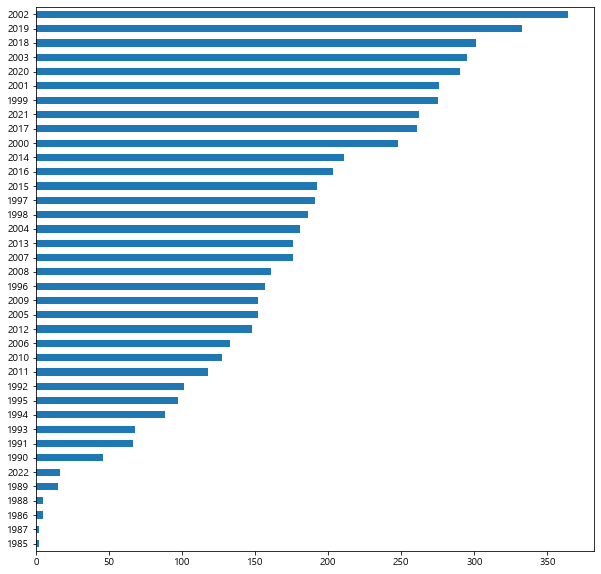

In [419]:
book_df['year'].value_counts().plot(kind='barh', figsize=(10,10)).invert_yaxis();

### 어느 달에 출판이 많이 되었나?

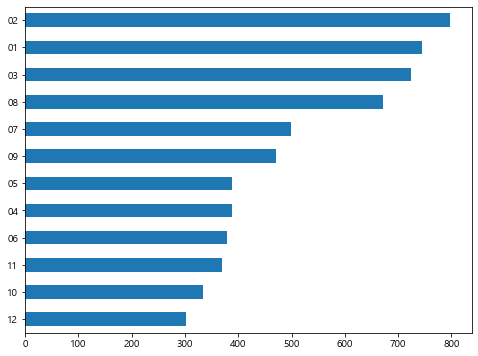

In [421]:
# '' 공백 데이터 제외된 df 복사
df_book_month = book_df[book_df['month'] != '']
df_book_month['month'].value_counts().plot(kind='barh', figsize=(8,6)).invert_yaxis();

    - 2월에 가장 많은 출판물이 발행되었으며, 1월, 3월이 그 다음으로 많은데, 연초~상반기 사이에 도서가 가장 많이 출판되는 것으로 보인다.
    - 그리고 6~8월에도 출판이 많이 되는데, 여름/휴가철을 타겟한 출판이 많은걸까?

### 국내 vs. 해외 출판사 출판물 수

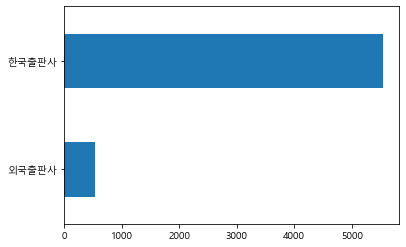

In [422]:
book_df['publisher_nationality'].value_counts().plot(kind='barh').invert_yaxis();

### 프로그래밍 언어별 출판 도서 총 개수

In [293]:
total_book_cnt_by_lang = pd.DataFrame(book_df['language'].value_counts())
total_book_cnt_by_lang

language
C                 1264
Java              1005
C++                971
Python             801
Visual Basic       599
SQL                422
JavaScript         380
C#                 280
R                  204
PHP                154

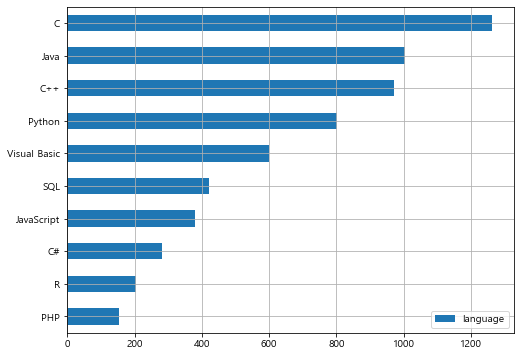

In [296]:
total_book_cnt_by_lang.plot(kind='barh', grid=True, figsize=(8,6)).invert_yaxis();

    - 지금까지 출판된 도서 중, C 언어와 관련된 도서가 가장 많으며, 이어서 Java, C++, Python 순서로 출판수가 많다

### 언어별 도서 출판수 추이 by 연도

In [297]:
book_df['count'] = 1 # count용 컬럼 추가

In [300]:
book_df.head(1)

title author    price  page_num publisher  \
0  누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)    전익진  17500.0     320.0  디스커버리미디어   

   pub_date  year month language publisher_nationality  count  
0  20220110  2022    01   Python                 한국출판사      1

In [298]:
#book_df.to_csv('./program_books_eda.csv', sep=',', encoding='utf-8', index=False) # 데이터 임시 저장

In [305]:
temp = book_df[book_df['year'].astype(int) < 2022]
book_cnt_lang_by_year = pd.pivot_table(temp, index='year', columns='language', values='count', aggfunc='sum')
book_cnt_lang_by_year

language     C    C#   C++   Java  JavaScript   PHP  Python     R   SQL  \
year                                                                      
1985       2.0   NaN   NaN    NaN         NaN   NaN     NaN   NaN   NaN   
1986       5.0   NaN   NaN    NaN         NaN   NaN     NaN   NaN   NaN   
1987       2.0   NaN   NaN    NaN         NaN   NaN     NaN   NaN   NaN   
1988       5.0   NaN   NaN    NaN         NaN   NaN     NaN   NaN   NaN   
1989      15.0   NaN   NaN    NaN         NaN   NaN     NaN   NaN   NaN   
1990      45.0   NaN   NaN    1.0         NaN   NaN     NaN   NaN   NaN   
1991      57.0   NaN   8.0    NaN         NaN   NaN     NaN   NaN   1.0   
1992      68.0   NaN  29.0    NaN         NaN   NaN     NaN   NaN   2.0   
1993      37.0   NaN  28.0    NaN         NaN   NaN     NaN   NaN   NaN   
1994      51.0   NaN  33.0    NaN         NaN   NaN     NaN   NaN   1.0   
1995      36.0   NaN  49.0    2.0         NaN   NaN     NaN   NaN   NaN   
1996      33.0   NaN  39.0   29.0         2.0   NaN     NaN   NaN   6.0   
1997      23.0   NaN  51.0   50.0        13.0   NaN     NaN   NaN   8.0   
1998      27.0   NaN  63.0   28.0         3.0   NaN     1.0   NaN   8.0   
1999      35.0   NaN  68.0   40.0         2.0   3.0     NaN   NaN  19.0   
2000      63.0   2.0  45.0   51.0        12.0  16.0     2.0   NaN  13.0   
2001      30.0  14.0  27.0   79.0        24.0  26.0     3.0   NaN  38.0   
2002      39.0  48.0  43.0  111.0        13.0  21.0     5.0   NaN  39.0   
2003      58.0  34.0  42.0   82.0         8.0   7.0     1.0   NaN  21.0   
2004      48.0  11.0  37.0   31.0         8.0   7.0     NaN   NaN  13.0   
2005      45.0  13.0  27.0   30.0         6.0   7.0     1.0   NaN  10.0   
2006      37.0   6.0  38.0   27.0         3.0   2.0     NaN   NaN   6.0   
2007      46.0  11.0  38.0   25.0         6.0   9.0     1.0   2.0  20.0   
2008      44.0   7.0  34.0   29.0        14.0   6.0     NaN   NaN  13.0   
2009      39.0  11.0  28.0   31.0        11.0   6.0     1.0   NaN  12.0   
2010      44.0   5.0  17.0   23.0         6.0   2.0     3.0   2.0  12.0   
2011      35.0   7.0  13.0   20.0        14.0   3.0     4.0   3.0   8.0   
2012      39.0   6.0  17.0   23.0        31.0   2.0     5.0   4.0  17.0   
2013      36.0   5.0  21.0   39.0        28.0   6.0     7.0   4.0  25.0   
2014      38.0  10.0  33.0   40.0        31.0   4.0    18.0  12.0  18.0   
2015      37.0  18.0  22.0   35.0        25.0   6.0    23.0  12.0  10.0   
2016      32.0  11.0  18.0   26.0        24.0   4.0    51.0  16.0  17.0   
2017      27.0  12.0  21.0   38.0        24.0   3.0    83.0  31.0  16.0   
2018      27.0  12.0  23.0   49.0        22.0   6.0   119.0  29.0  13.0   
2019      22.0  17.0  27.0   28.0        18.0   4.0   166.0  28.0  22.0   
2020      14.0   9.0  23.0   19.0        12.0   2.0   162.0  31.0  16.0   
2021      19.0  10.0   8.0   19.0        19.0   2.0   137.0  30.0  17.0   

language  Visual Basic  
year                    
1985               NaN  
1986               NaN  
1987               NaN  
1988               NaN  
1989               NaN  
1990               NaN  
1991               NaN  
1992               2.0  
1993               3.0  
1994               3.0  
1995              10.0  
1996              48.0  
1997              46.0  
1998              56.0  
1999             108.0  
2000              44.0  
2001              35.0  
2002              45.0  
2003              42.0  
2004              26.0  
2005              13.0  
2006              14.0  
2007              18.0  
2008              14.0  
2009              13.0  
2010              13.0  
2011              11.0  
2012               4.0  
2013               5.0  
2014               7.0  
2015               4.0  
2016               4.0  
2017               6.0  
2018               1.0  
2019               1.0  
2020               2.0  
2021               1.0

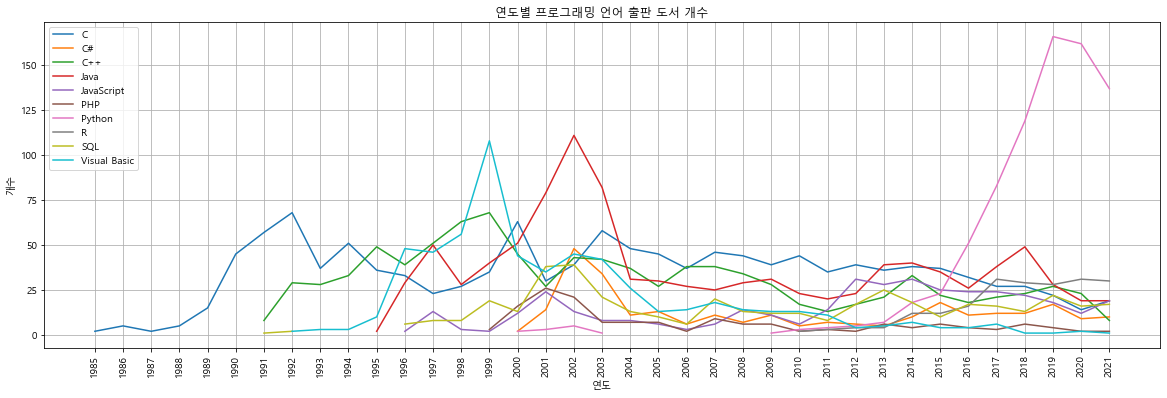

In [306]:
plt.figure(figsize=(20, 6))
plt.title('연도별 프로그래밍 언어 출판 도서 개수')
plt.xlabel('연도')
plt.ylabel('개수')
plt.plot(book_cnt_lang_by_year.index, book_cnt_lang_by_year.values)
plt.legend(book_cnt_lang_by_year.columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

- 역사가 오래 된 C 언어와 관련된 출판물은 오래 전부터 있어온 것을 볼 수 있다.
- Visual Basic의 경우 1999년에, Java의 경우 2002년에 가장 많은 출판물이 발행되었다.
- Python 관련 출판물 수는 2010년부터 증가하기 시작하였고, 급격하게 증가하다 2019년 피크를 찍었다.

### Python 출판물 수 및 전년대비 증가율

In [310]:
# 2021년까지의 Python 관련 출판 도서 dataframe
df_python = book_df[(book_df['language'] == 'Python') & (book_df['year'].astype(int) < 2022)]
df_python.head(3)

title   author    price  \
8   알고리즘 구현으로 배우는 선형대수 with 파이썬 (행렬의 기초부터 텐서를 활용한 ...      장철원  34000.0   
9                        파이썬 무작정 따라하기 (미래의 프로그래머를 위한)  송석리|서승희  16000.0   
10  생활코딩 머신러닝 실습편 with 파이썬 텐서플로 (누구나 쉽게 시작하는 인공지능 ...  이숙번|이고잉  24000.0   

    page_num publisher  pub_date  year month language publisher_nationality  \
8      592.0    비제이퍼블릭  20211224  2021    12   Python                 한국출판사   
9      248.0        길벗  20211220  2021    12   Python                 한국출판사   
10     320.0      위키북스  20211215  2021    12   Python                 한국출판사   

    count  
8       1  
9       1  
10      1

In [311]:
# python 관련 도서 연도별 출판물 수
python_cnt_year = df_python.pivot_table(values='count', columns='year', aggfunc='sum').T
python_cnt_year

count
year       
1998      1
2000      2
2001      3
2002      5
2003      1
2005      1
2007      1
2009      1
2010      3
2011      4
2012      5
2013      7
2014     18
2015     23
2016     51
2017     83
2018    119
2019    166
2020    162
2021    137

In [312]:
# python 출판물 전년대비 증가율
python_increase_rate = df_python.pivot_table(values='count', columns='year', aggfunc='sum').pct_change(axis='columns').T*100
python_increase_rate

count
year            
1998         NaN
2000  100.000000
2001   50.000000
2002   66.666667
2003  -80.000000
2005    0.000000
2007    0.000000
2009    0.000000
2010  200.000000
2011   33.333333
2012   25.000000
2013   40.000000
2014  157.142857
2015   27.777778
2016  121.739130
2017   62.745098
2018   43.373494
2019   39.495798
2020   -2.409639
2021  -15.432099

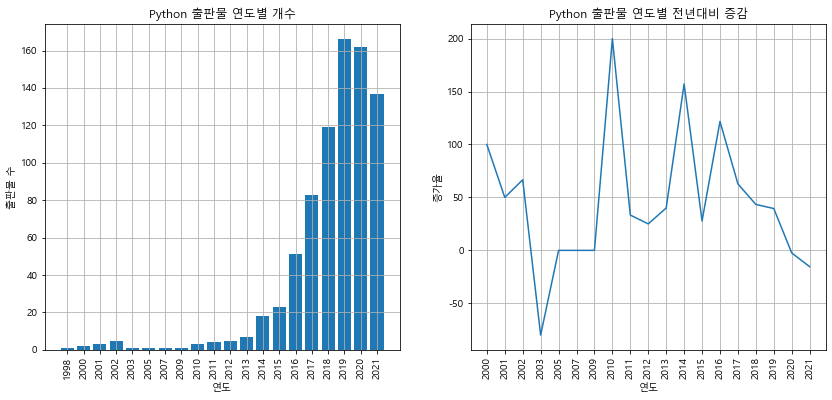

In [313]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.bar(python_cnt_year.reset_index()['year'], python_cnt_year.reset_index()['count'])
plt.title('Python 출판물 연도별 개수')
plt.xlabel('연도')
plt.ylabel('출판물 수')
plt.grid(True)
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.plot(python_increase_rate.index, python_increase_rate.values)
plt.title('Python 출판물 연도별 전년대비 증감')
plt.xlabel('연도')
plt.ylabel('증가율')
plt.grid(True)
plt.xticks(rotation='vertical')

plt.show();

- Python 관련 출판물 수는 2010년부터 2019년까지 매년 증가세를 보여주었는데, 특히 전년대비 2014년엔 157%, 2016년엔 121% 증가하였다. 가장 많은 출판물 수를 기록한 2019년도 전년대비 40% 증가한 수치다.
- 2019년 이후 Python 관련 출판물 수는 전년대비 감소세를 보이고 있지만, 매년 100권이 넘는 출판이 지속되고 있어 그 인기가 여전함을 알 수 있다. 

## 2. 프로그래밍 언어 출판물 가격 분석

### 프로그래밍 언어별 도서 가격

In [319]:
# 모든 연도 포함한 기준 언어별 책 가격 평균 조회
round(book_df.groupby('language')['price'].agg('mean'))

language
C               17300.0
C#              26535.0
C++             21678.0
Java            23584.0
JavaScript      23107.0
PHP             23200.0
Python          25077.0
R               26355.0
SQL             24993.0
Visual Basic    18976.0
Name: price, dtype: float64

In [320]:
# 모든 연도 포함한 기준 언어별 책 가격 중간 값 조회
book_df.groupby('language')['price'].agg('median')

language
C               16000.0
C#              25000.0
C++             20000.0
Java            23000.0
JavaScript      22000.0
PHP             22500.0
Python          25000.0
R               26000.0
SQL             25000.0
Visual Basic    18000.0
Name: price, dtype: float64

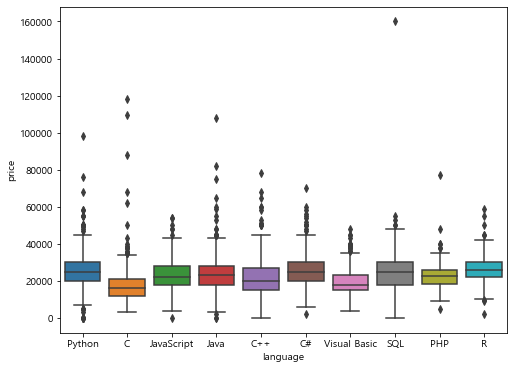

In [321]:
# boxplot으로 시각화
plt.figure(figsize=(8,6))
sns.boxplot(x='language', y='price', data=book_df)
plt.show();

### 최근 7년의 연도별, 월별 가격 분포

In [322]:
df_book_2015_2021 = book_df[book_df['year'].isin(['2015','2016','2017','2018','2019','2020','2021'])].sort_values(['year','month'], ascending=True)
df_book_2015_2021.head(3)

title     author    price  \
3592                                     C++ 프로그래밍의 정석         최정훈  27000.0   
603   파이썬을 활용한 네트워크 프로그래밍 (개발자와 관리자를 위한 효율적인 네트워크 애플...     파루크 사커  30000.0   
604   matplotlib을 이용한 데이터 시각화 프로그래밍 (파이썬으로 구현하는 데이터 ...  알렉상드르 드베르  25000.0   

      page_num publisher  pub_date  year month language publisher_nationality  \
3592     448.0     삼창미디어      2015  2015            C++                 한국출판사   
603      288.0     에이콘출판  20150127  2015    01   Python                 한국출판사   
604      256.0     에이콘출판  20150116  2015    01   Python                 한국출판사   

      count  
3592      1  
603       1  
604       1

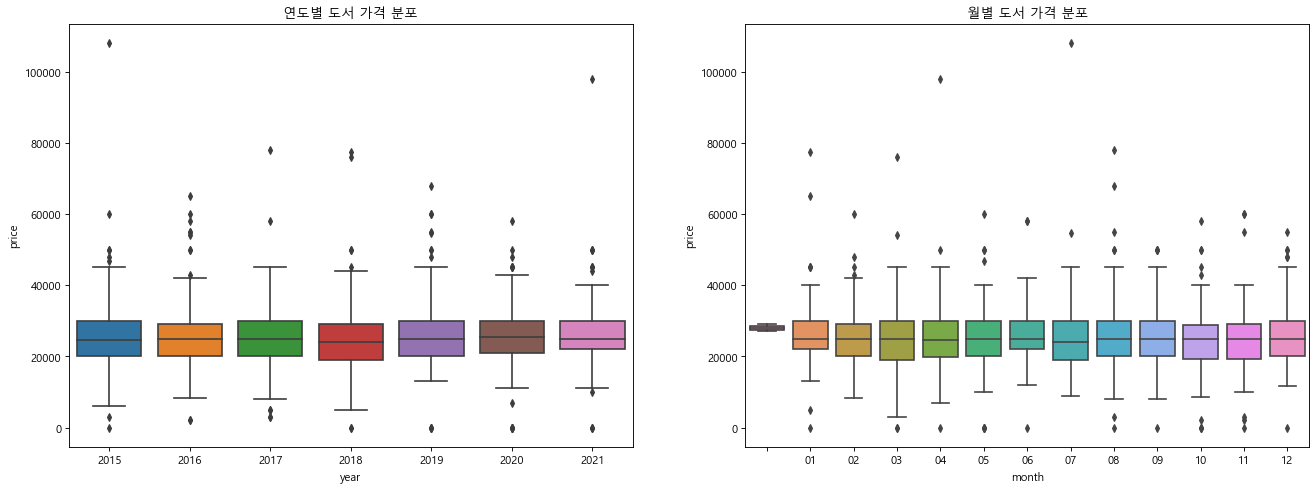

In [324]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi=80)
sns.boxplot(x='year', y='price', data=df_book_2015_2021, ax=axes[0])
sns.boxplot(x='month', y='price', data=df_book_2015_2021)
axes[0].set_title('연도별 도서 가격 분포')
axes[1].set_title('월별 도서 가격 분포')
plt.show();

### 최근 7년 Python 관련 도서 연도별, 월별 가격 분포

In [325]:
df_python_book_2015_2021 = df_book_2015_2021[df_book_2015_2021['language'] == 'Python']

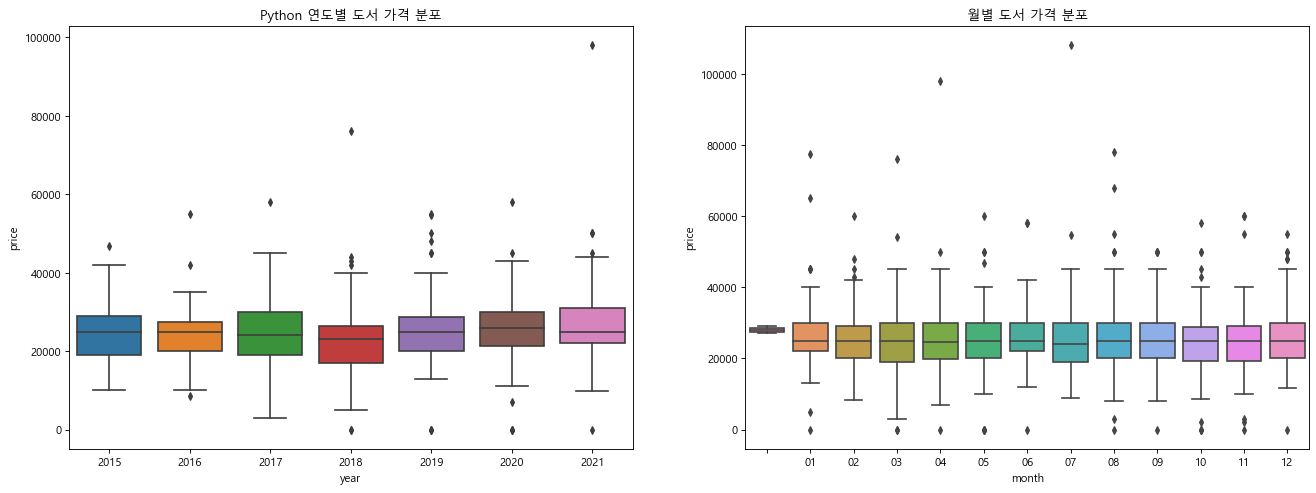

In [326]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi=80)
sns.boxplot(x='year', y='price', data=df_python_book_2015_2021, ax=axes[0])
sns.boxplot(x='month', y='price', data=df_book_2015_2021)
axes[0].set_title('Python 연도별 도서 가격 분포')
axes[1].set_title('월별 도서 가격 분포')
plt.show();

### 프로그래밍 언어별 책 평균 가격에 대한 연도별 추이

In [327]:
# 연도별 프로그래밍 언어 도서 평균 가격
temp = book_df[book_df['year'].astype(int) < 2022]
avg_price_lang_by_year = pd.pivot_table(temp, values='price', index='year', columns='language', aggfunc='mean')
avg_price_lang_by_year

language             C            C#           C++          Java  \
year                                                               
1985       5000.000000           NaN           NaN           NaN   
1986       8000.000000           NaN           NaN           NaN   
1987       6000.000000           NaN           NaN           NaN   
1988      10600.000000           NaN           NaN           NaN   
1989      10800.000000           NaN           NaN           NaN   
1990       7911.111111           NaN           NaN  15000.000000   
1991       8859.649123           NaN  10875.000000           NaN   
1992      10977.941176           NaN  12034.482759           NaN   
1993      12418.918919           NaN  14464.285714           NaN   
1994      13509.803922           NaN  15287.878788           NaN   
1995      12375.000000           NaN  16367.346939  10000.000000   
1996      13348.484848           NaN  17346.153846  13586.206897   
1997      13043.478261           NaN  20725.490196  19700.000000   
1998      14925.925926           NaN  20817.460317  18357.142857   
1999      14694.285714           NaN  20722.058824  20975.000000   
2000      15587.301587  25000.000000  17555.555556  21598.039216   
2001      16400.000000  25785.714286  19703.703704  23790.886076   
2002      17738.461538  27270.833333  22251.162791  23745.945946   
2003      17665.517241  24441.176471  21923.809524  22393.902439   
2004      18533.333333  23636.363636  22864.864865  22480.645161   
2005      19057.777778  21230.769231  22370.370370  23733.333333   
2006      19243.243243  22000.000000  20863.157895  24148.148148   
2007      18119.565217  28454.545455  22763.157895  21640.000000   
2008      20726.363636  24857.142857  21729.411765  23606.896552   
2009      19717.948718  29000.000000  26607.142857  25580.645161   
2010      23988.636364  20400.000000  26882.352941  24434.782609   
2011      20197.142857  26142.857143  26307.692308  26800.000000   
2012      23102.564103  38833.333333  22117.647059  26573.913043   
2013      25111.111111  37800.000000  27752.380952  25120.512821   
2014      22310.526316  30100.000000  22554.545455  27260.000000   
2015      21432.432432  24622.222222  26700.000000  29365.714286   
2016      23937.500000  32400.000000  29177.777778  24869.230769   
2017      22185.185185  23933.333333  28257.142857  24689.473684   
2018      21833.333333  26000.000000  27652.173913  24206.122449   
2019      23590.909091  28352.941176  30081.481481  29678.571429   
2020      21985.714286  25000.000000  29434.782609  24684.210526   
2021      24578.947368  27300.000000  36000.000000  27578.947368   

language    JavaScript           PHP        Python             R  \
year                                                               
1985               NaN           NaN           NaN           NaN   
1986               NaN           NaN           NaN           NaN   
1987               NaN           NaN           NaN           NaN   
1988               NaN           NaN           NaN           NaN   
1989               NaN           NaN           NaN           NaN   
1990               NaN           NaN           NaN           NaN   
1991               NaN           NaN           NaN           NaN   
1992               NaN           NaN           NaN           NaN   
1993               NaN           NaN           NaN           NaN   
1994               NaN           NaN           NaN           NaN   
1995               NaN           NaN           NaN           NaN   
1996      11000.000000           NaN           NaN           NaN   
1997      16176.923077           NaN           NaN           NaN   
1998      24000.000000           NaN  17000.000000           NaN   
1999      25000.000000  16000.000000           NaN           NaN   
2000      16416.666667  20562.500000  16300.000000           NaN   
2001      17816.666667  22230.769231  19666.666667           NaN   
2002      19215.384615  22190.476190  28200.000000     

In [328]:
avg_price_lang_by_year.columns

Index(['C', 'C#', 'C++', 'Java', 'JavaScript', 'PHP', 'Python', 'R', 'SQL',
       'Visual Basic'],
      dtype='object', name='language')

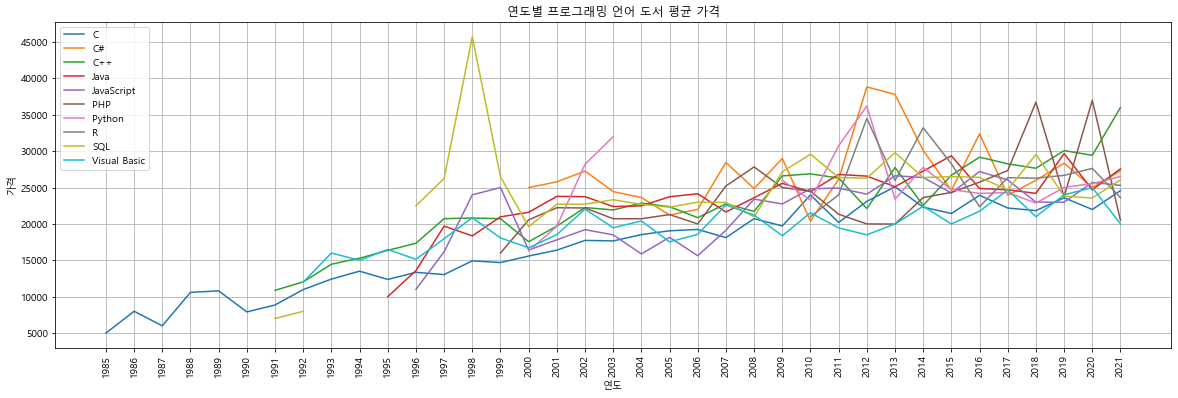

In [329]:
plt.figure(figsize=(20, 6))
plt.title('연도별 프로그래밍 언어 도서 평균 가격')
plt.xlabel('연도')
plt.ylabel('가격')
plt.plot(avg_price_lang_by_year.index,avg_price_lang_by_year.values)
plt.legend(avg_price_lang_by_year.columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

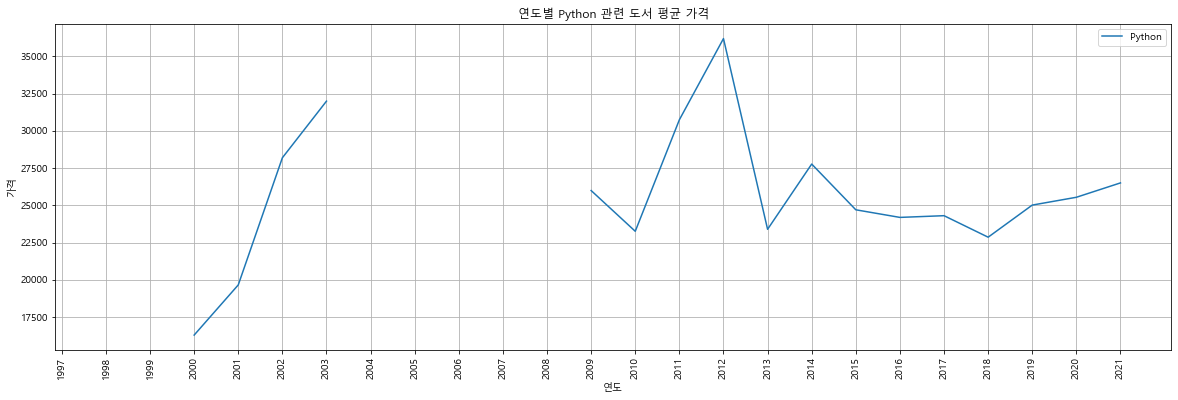

In [426]:
# Python 관련
plt.figure(figsize=(20, 6))
plt.title('연도별 Python 관련 도서 평균 가격')
plt.xlabel('연도')
plt.ylabel('가격')
plt.plot(avg_price_lang_by_year['Python'].to_frame().index,avg_price_lang_by_year['Python'].to_frame().values)
plt.legend(avg_price_lang_by_year['Python'].to_frame().columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

In [330]:
# 연도별 프로그래밍 언어 도서 중간 가격
temp = book_df[book_df['year'].astype(int) < 2022]
mid_price_lang_by_year = pd.pivot_table(temp, values='price', index='year', columns='language', aggfunc='median')
mid_price_lang_by_year

language        C       C#      C++     Java  JavaScript      PHP   Python  \
year                                                                         
1985       5000.0      NaN      NaN      NaN         NaN      NaN      NaN   
1986       7000.0      NaN      NaN      NaN         NaN      NaN      NaN   
1987       6000.0      NaN      NaN      NaN         NaN      NaN      NaN   
1988       9000.0      NaN      NaN      NaN         NaN      NaN      NaN   
1989       8500.0      NaN      NaN      NaN         NaN      NaN      NaN   
1990       8000.0      NaN      NaN  15000.0         NaN      NaN      NaN   
1991       8000.0      NaN  10500.0      NaN         NaN      NaN      NaN   
1992      10000.0      NaN  12000.0      NaN         NaN      NaN      NaN   
1993      12000.0      NaN  15000.0      NaN         NaN      NaN      NaN   
1994      15000.0      NaN  15000.0      NaN         NaN      NaN      NaN   
1995      12500.0      NaN  16000.0  10000.0         NaN      NaN      NaN   
1996      13000.0      NaN  16000.0  12000.0     11000.0      NaN      NaN   
1997      12000.0      NaN  20000.0  17500.0     15000.0      NaN      NaN   
1998      15000.0      NaN  18000.0  18000.0     18000.0      NaN  17000.0   
1999      15000.0      NaN  18000.0  20000.0     25000.0  15000.0      NaN   
2000      15000.0  25000.0  16000.0  20000.0     15500.0  19000.0  16300.0   
2001      16000.0  25000.0  18000.0  23000.0     18000.0  21000.0  20000.0   
2002      16000.0  27000.0  20000.0  23000.0     18000.0  22000.0  25000.0   
2003      17000.0  23000.0  20000.0  20500.0     18500.0  22000.0  32000.0   
2004      16900.0  20000.0  20000.0  22000.0     15500.0  24000.0      NaN   
2005      18000.0  22000.0  20000.0  24000.0     18000.0  22000.0  35000.0   
2006      19000.0  22000.0  20000.0  22000.0     15000.0  20000.0      NaN   
2007      17000.0  21000.0  20000.0  20000.0     18900.0  25000.0  17000.0   
2008      19000.0  22000.0  20000.0  23000.0     21000.0  28500.0      NaN   
2009      20000.0  29000.0  25000.0  24000.0     20000.0  24000.0  26000.0   
2010      22000.0  19000.0  26000.0  25000.0     21500.0  24500.0  25000.0   
2011      20000.0  25000.0  25000.0  26000.0     23500.0  22000.0  28000.0   
2012      25000.0  41500.0  20000.0  25000.0     25000.0  20000.0  38000.0   
2013      22000.0  35000.0  29000.0  25000.0     25500.0  21000.0  24000.0   
2014      20500.0  25000.0  22000.0  25500.0     26000.0  22500.0  25000.0   
2015      22000.0  25000.0  26000.0  27000.0     24000.0  25000.0  25000.0   
2016      24000.0  25000.0  26000.0  27000.0     25000.0  26500.0  25000.0   
2017      22000.0  22500.0  27000.0  25300.0     26500.0  30000.0  24000.0   
2018      22000.0  26000.0  25000.0  24000.0     23000.0  29500.0  23000.0   
2019      22000.0  26000.0  28000.0  29000.0     23500.0  23500.0  25000.0   
2020      19500.0  25000.0  30000.0  25000.0     23000.0  37000.0  26000.0   
2021      25000.0  25500.0  36000.0  30000.0     25000.0  20500.0  25000.0   

language        R      SQL  Visual Basic  
year                                      
1985          NaN      NaN           NaN  
1986          NaN      NaN           NaN  
1987          NaN      NaN           NaN  
1988          NaN      NaN           NaN  
1989          NaN      NaN           NaN  
1990          NaN      NaN           NaN  
1991          NaN   7000.0           NaN  
1992          NaN   8000.0       12000.0  
1993          NaN      NaN       15000.0  
1994          NaN  10000.0       15000.0  
1995          NaN      NaN       15000.0  
1996          NaN  19500.0       15500.0  
1997          NaN  27000.0       17000.0  
1998          NaN  35000.0       19500.0  
1999          NaN  20000.0       17000.0  
2000          NaN  18000.0       16000.0  
2001          NaN  20000.0       17000.0  
2002          NaN  21000.0       22000.0  
2003          NaN  22800.0       18000.0  
2004          NaN  20000.0       19500.0  
2005       

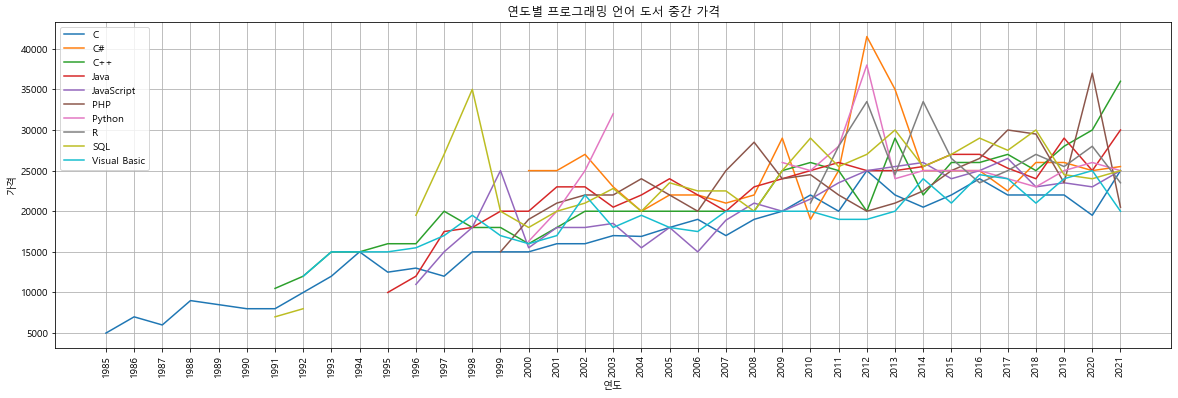

In [331]:
plt.figure(figsize=(20, 6))
plt.title('연도별 프로그래밍 언어 도서 중간 가격')
plt.xlabel('연도')
plt.ylabel('가격')
plt.plot(mid_price_lang_by_year.index,mid_price_lang_by_year.values)
plt.legend(mid_price_lang_by_year.columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

## 국내 출판사 분석

In [338]:
pub_korea = book_df[book_df['publisher_nationality'] == '한국출판사']

### 프로그래밍 도서 출판물 수 기준 국내 top 10 출판사

In [333]:
top_pub_korea = pd.DataFrame(pub_korea['publisher'].value_counts().head(10))
top_pub_korea

publisher
한빛미디어          362
에이콘출판          278
정보문화사          268
영진닷컴           227
성안당            134
홍릉과학출판사        119
위키북스           112
대림             110
길벗             107
인포북            105

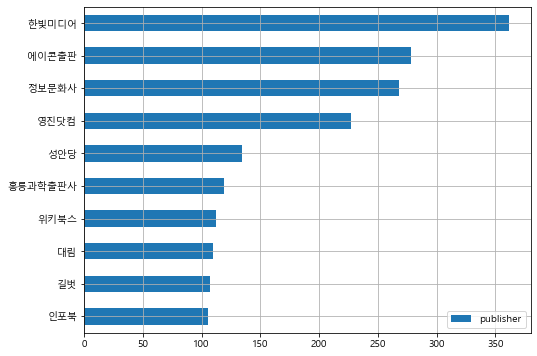

In [334]:
top_pub_korea.plot(kind='barh', grid=True, figsize=(8,6)).invert_yaxis();

    - 국내 출판사 중에선 한빛미디어가 가장 많은 프로그래밍 언어 관련 도서를 출판했으며, 이어 에이콘출판, 정보문화사 등이 있다.

### 국내 Top 10 출판사별 출판물 수 추이

In [339]:
# 국내 10대 출판사만 dataframe
df_top_pub_korea = pub_korea[pub_korea['publisher'].isin(top_pub_korea.index)]

In [340]:
temp = df_top_pub_korea[df_top_pub_korea['year'].astype(int) < 2022]
cnt_books_top_pub_korea = temp.pivot_table(values='count', index='year', columns='publisher', aggfunc='sum')
cnt_books_top_pub_korea

publisher    길벗    대림   성안당  에이콘출판  영진닷컴  위키북스   인포북  정보문화사  한빛미디어  홍릉과학출판사
year                                                                       
1989        NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN    NaN      1.0
1990        NaN   NaN   NaN    NaN   1.0   NaN   NaN    NaN    NaN      NaN
1991        NaN   NaN   NaN    NaN   1.0   NaN   NaN    1.0    NaN      NaN
1992        NaN   4.0   NaN    NaN   8.0   NaN   NaN    1.0    NaN      NaN
1993        NaN   1.0   1.0    NaN   5.0   NaN   NaN    2.0    NaN      NaN
1994        NaN   3.0   5.0    NaN   3.0   NaN   1.0    2.0    NaN      NaN
1995        NaN   1.0   1.0    NaN   4.0   NaN   8.0    3.0    NaN      1.0
1996        NaN   8.0  11.0    NaN   3.0   NaN   4.0    7.0    NaN      1.0
1997        NaN  12.0   5.0    NaN  12.0   NaN  13.0   13.0    1.0      1.0
1998        NaN   8.0   8.0    NaN  12.0   NaN  10.0   14.0    3.0      3.0
1999        NaN  12.0   6.0    NaN  19.0   NaN   8.0   23.0    3.0      3.0
2000        NaN   6.0   2.0    NaN   7.0   NaN  10.0   20.0   15.0      6.0
2001        1.0  13.0   3.0    NaN  16.0   NaN   8.0   27.0   21.0     11.0
2002        3.0   7.0   3.0    3.0  43.0   NaN  19.0   48.0   13.0     10.0
2003        7.0   8.0  13.0    NaN  26.0   NaN  21.0   19.0   12.0     12.0
2004        1.0   1.0   5.0    3.0  11.0   NaN   3.0   10.0    8.0     17.0
2005        1.0   5.0   6.0    1.0  10.0   NaN   NaN    7.0   11.0      7.0
2006        NaN   8.0   5.0    2.0   1.0   NaN   NaN   11.0   11.0      3.0
2007        3.0   7.0   NaN    2.0   2.0   1.0   NaN    8.0    9.0      6.0
2008        1.0   2.0   3.0    7.0   4.0   2.0   NaN    6.0   18.0      1.0
2009        1.0   4.0   5.0    3.0   3.0   2.0   NaN    6.0    9.0      3.0
2010        NaN   NaN   1.0    5.0   1.0   3.0   NaN    1.0    5.0      4.0
2011        1.0   NaN   2.0    4.0   2.0   3.0   NaN    NaN   13.0      4.0
2012        2.0   NaN   1.0   17.0   2.0   7.0   NaN    2.0   13.0      3.0
2013        3.0   NaN   4.0   16.0   3.0   4.0   NaN    4.0   19.0      4.0
2014        4.0   NaN   4.0   23.0   1.0  10.0   NaN    3.0   33.0      1.0
2015        6.0   NaN   3.0   25.0   3.0  11.0   NaN    5.0   28.0      3.0
2016        9.0   NaN   3.0   31.0   1.0   5.0   NaN    2.0   21.0      1.0
2017       13.0   NaN   8.0   36.0   1.0  10.0   NaN    4.0   15.0      4.0
2018       13.0   NaN  10.0   32.0   3.0   8.0   NaN    7.0   18.0      2.0
2019       14.0   NaN   6.0   35.0   6.0  20.0   NaN    5.0   27.0      6.0
2020       12.0   NaN   2.0   15.0   5.0  14.0   NaN    3.0   14.0      1.0
2021       12.0   NaN   8.0   18.0   7.0  12.0   NaN    4.0   22.0      NaN

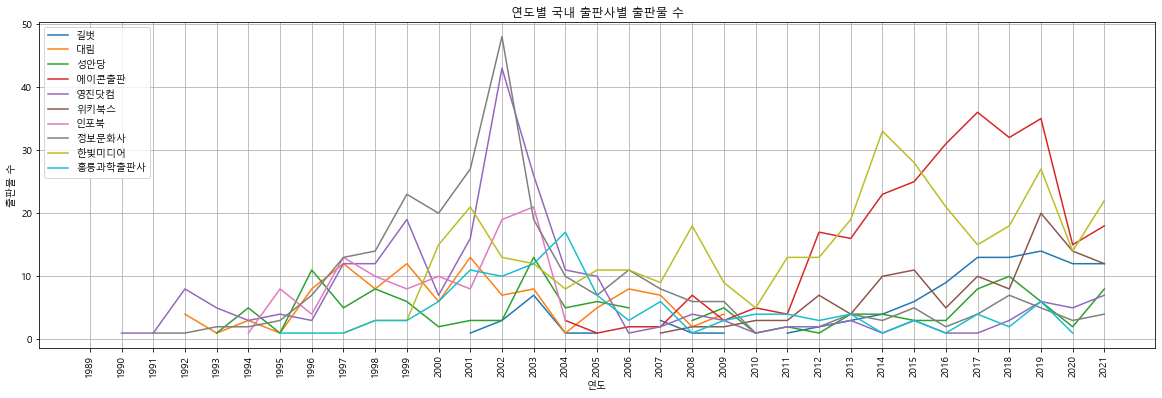

In [341]:
plt.figure(figsize=(20, 6))
plt.title('연도별 국내 출판사별 출판물 수')
plt.xlabel('연도')
plt.ylabel('출판물 수')
plt.plot(cnt_books_top_pub_korea.index,cnt_books_top_pub_korea.values)
plt.legend(cnt_books_top_pub_korea.columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

### 국내 Top10 출판사별 Python 관련 출판물 수 추이

In [349]:
df_python_top_pub_korea = df_top_pub_korea[df_top_pub_korea['language'] == 'Python']
cnt_python_top_pub_korea = df_python_top_pub_korea.pivot_table(values='count', index='year', columns='publisher', aggfunc='sum')

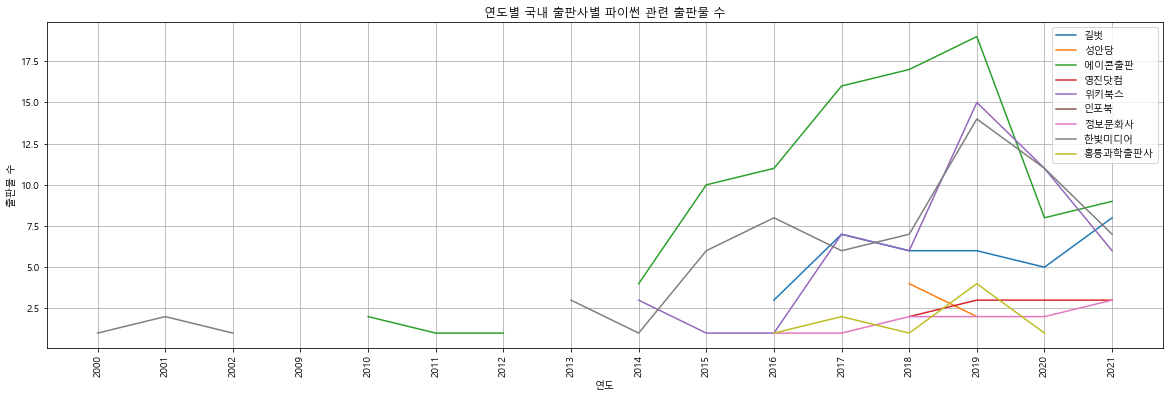

In [344]:
plt.figure(figsize=(20, 6))
plt.title('연도별 국내 출판사별 파이썬 관련 출판물 수')
plt.xlabel('연도')
plt.ylabel('출판물 수')
plt.plot(cnt_python_top_pub_korea.index,cnt_python_top_pub_korea.values)
plt.legend(cnt_python_top_pub_korea.columns, loc='best')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

- 국내 Top10 출판스들은 2013년 이후 Python 관련 도서를 많이 출판하기 시작했다. 특히, 에이콘출판사가 Python 관련 도서 출판 수에 있어 많은 출판물을 보유하고 있고, 이어서 한빛미디어, 위키북스, 길벗 출판사가 많은 출판을 하였다.

### 국내 출판사 vs. 국외 출판사 Python 출판물 수 비교

In [345]:
df_python = book_df[book_df['language'] == 'Python']
df_python.head(3)

title          author    price  page_num  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)             전익진  17500.0     320.0   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)             박영권  22000.0     388.0   
2                        파이썬 딥러닝 프로젝트  Matthew Lamons  39000.0     461.0   

  publisher  pub_date  year month language publisher_nationality  count  
0  디스커버리미디어  20220110  2022    01   Python                 한국출판사      1  
1       시대인  20220110  2022    01   Python                 한국출판사      1  
2        홍릉  20220107  2022    01   Python                 한국출판사      1

In [346]:
df_python.groupby(['publisher_nationality'])['count'].agg('sum')

publisher_nationality
외국출판사     82
한국출판사    719
Name: count, dtype: int64

In [350]:
temp = df_python[df_python['year'].astype(int) < 2022]
cnt_python_domestic_foregin = temp.pivot_table(values='count', index='year', columns='publisher_nationality', aggfunc='sum')

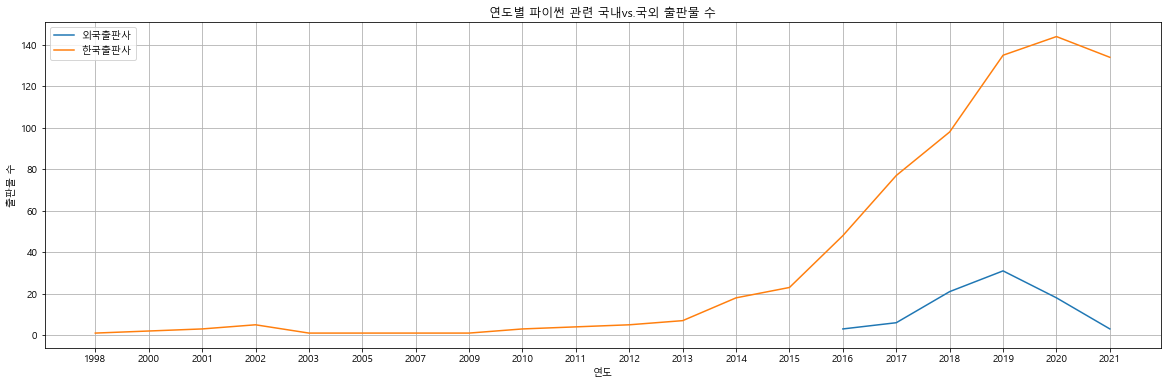

In [352]:
plt.figure(figsize=(20, 6))
plt.title('연도별 파이썬 관련 국내vs.국외 출판물 수')
plt.xlabel('연도')
plt.ylabel('출판물 수')
plt.plot(cnt_python_domestic_foregin.index,cnt_python_domestic_foregin.values)
plt.legend(cnt_python_domestic_foregin.columns, loc='best')
plt.xticks(rotation=0)
plt.grid(True)
plt.tick_params(bottom='off', labelbottom='off') # tick_params(): 눈금선 스타일 설정
plt.show()

- 2015년 이후 국내 출판사들의 Python 관련 도서 출판 수가 급격히 증가하였는데, 비슷한 시기에 해외에서 출판된 Python 관련 도서들도 국내로 유입되기 시작한 것으로 보인다.

## 2016-18년 vs. 2019-21년 기간별 분석

### 16-18년 vs. 19-21년 데이터 준비

In [353]:
book_df.head(2)

title author    price  page_num publisher  \
0      누구나 파이썬 (기초부터 시작하는 코딩과 데이터 분석)    전익진  17500.0     320.0  디스커버리미디어   
1  파이썬 프로그래밍 (기초부터 실전 프로그래밍까지 한 권에 끝)    박영권  22000.0     388.0       시대인   

   pub_date  year month language publisher_nationality  count  
0  20220110  2022    01   Python                 한국출판사      1  
1  20220110  2022    01   Python                 한국출판사      1

In [355]:
# 별도 데이터셋 생성
# 16-18년
df_books_p1 = book_df[(book_df['year'] == '2016') | (book_df['year'] == '2017') | (book_df['year'] == '2018')]
df_books_p1.head(1)

title author    price  page_num publisher  pub_date  year  \
385  자료분석을 위한 파이썬 프로그램    박진표  25000.0     457.0  경남대학교출판부  20181221  2018   

    month language publisher_nationality  count  
385    12   Python                 한국출판사      1

In [354]:
# 19-21년
df_books_p2 = book_df[(book_df['year'] == '2019') | (book_df['year'] == '2020') | (book_df['year'] == '2021')]
df_books_p2.head(1)

title author    price  \
8  알고리즘 구현으로 배우는 선형대수 with 파이썬 (행렬의 기초부터 텐서를 활용한 ...    장철원  34000.0   

   page_num publisher  pub_date  year month language publisher_nationality  \
8     592.0    비제이퍼블릭  20211224  2021    12   Python                 한국출판사   

   count  
8      1

### 2016-18 vs. 2019-21 언어별 출판물 수

In [358]:
# 16-18년, 19-21년 출판물 수
cnt_books_p1 = pd.DataFrame(df_books_p1['language'].value_counts(sort=False)).reset_index()
cnt_books_p2 = pd.DataFrame(df_books_p2['language'].value_counts(sort=False)).reset_index()
cnt_books_merged = cnt_books_p1.merge(cnt_books_p2, how='outer', on='index', suffixes=('_2016_2018', ('_2019_2021')))
cnt_books_merged

index  language_2016_2018  language_2019_2021
0        Python                 253                 465
1             C                  86                  55
2    JavaScript                  70                  49
3          Java                 113                  66
4           C++                  62                  58
5            C#                  35                  36
6  Visual Basic                  11                   4
7           SQL                  46                  55
8           PHP                  13                   8
9             R                  76                  89

In [359]:
# 16-18년 대비 19-21년 출판물 수 증감
cnt_books_merged.set_index('index').pct_change(axis='columns')*100

language_2016_2018  language_2019_2021
index                                               
Python                       NaN           83.794466
C                            NaN          -36.046512
JavaScript                   NaN          -30.000000
Java                         NaN          -41.592920
C++                          NaN           -6.451613
C#                           NaN            2.857143
Visual Basic                 NaN          -63.636364
SQL                          NaN           19.565217
PHP                          NaN          -38.461538
R                            NaN           17.105263

In [360]:
cnt_books_merged.merge(cnt_books_merged.set_index('index').pct_change(axis='columns')*100, how='outer', on='index', suffixes=('', '_change_rate'))

index  language_2016_2018  language_2019_2021  \
0        Python                 253                 465   
1             C                  86                  55   
2    JavaScript                  70                  49   
3          Java                 113                  66   
4           C++                  62                  58   
5            C#                  35                  36   
6  Visual Basic                  11                   4   
7           SQL                  46                  55   
8           PHP                  13                   8   
9             R                  76                  89   

   language_2016_2018_change_rate  language_2019_2021_change_rate  
0                             NaN                       83.794466  
1                             NaN                      -36.046512  
2                             NaN                      -30.000000  
3                             NaN                      -41.592920  
4                             NaN                       -6.451613  
5                             NaN                        2.857143  
6                             NaN                      -63.636364  
7                             NaN                       19.565217  
8                             NaN                      -38.461538  
9                             NaN                       17.105263

<AxesSubplot:>

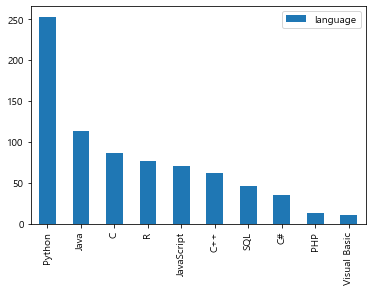

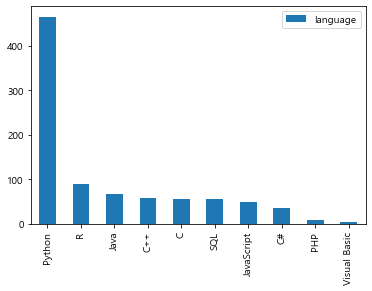

In [361]:
pd.DataFrame(df_books_p1['language'].value_counts(sort=True)).plot(kind='bar')
pd.DataFrame(df_books_p2['language'].value_counts(sort=True)).plot(kind='bar')

In [362]:
cnt_books_p1['index'].unique()

array(['Python', 'C', 'JavaScript', 'Java', 'C++', 'C#', 'Visual Basic',
       'SQL', 'PHP', 'R'], dtype=object)

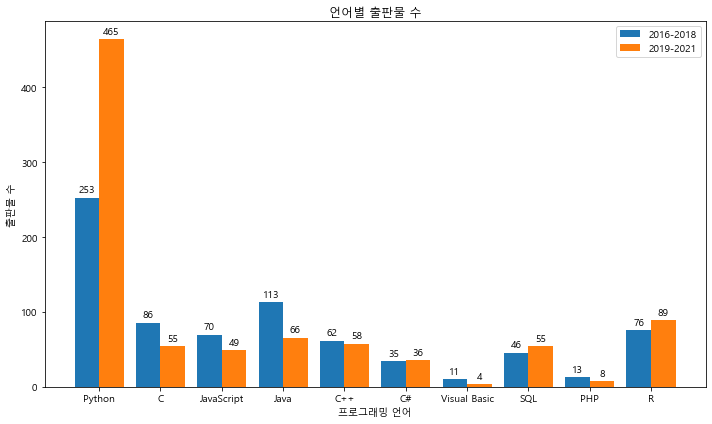

In [363]:
width = 0.4

fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(cnt_books_p1['index'].unique()))
p1 = ax.bar(x - 0.2, cnt_books_p1.language, width, label='2016-2018')
p2 = ax.bar(x + 0.2, cnt_books_p2.language, width, label='2019-2021')

ax.set_xlabel('프로그래밍 언어')
ax.set_ylabel('출판물 수')
ax.set_title('언어별 출판물 수')
ax.set_xticks(x)
ax.set_xticklabels(cnt_books_p1['index'].unique())
ax.legend()

ax.bar_label(p1, padding=3)
ax.bar_label(p2, padding=3)

fig.tight_layout()
plt.show();

- Python과 관려된 출판물 수가 2016-2018년, 2019-2021년 두 기간 모두 가장 많다.
- 대부분의 프로그래밍 언어가 2016-2018년 대비 2019-2021년 출판물 수가 감소하거나 비슷하게 나타난 반면, Python은 약 +84% 증가하였다.

### 2016-18 vs. 2019-21년 출판물 평균 가격

In [364]:
df_books_p1.head(3)

title       author    price  page_num  \
385                   자료분석을 위한 파이썬 프로그램          박진표  25000.0     457.0   
386  파이썬 쉽게, 더 쉽게 (친절한 설명과 다양한 예제로 배우는)        츠지 신고  26000.0     404.0   
387              아두이노와 피지컬 컴퓨팅 with 파이썬  이원규|김자미|장윤재  16000.0     260.0   

    publisher  pub_date  year month language publisher_nationality  count  
385  경남대학교출판부  20181221  2018    12   Python                 한국출판사      1  
386       제이펍  20181220  2018    12   Python                 한국출판사      1  
387       교학사  20181220  2018    12   Python                 한국출판사      1

In [366]:
# 16-18년, 19-21년 출판물 평균 가격
avg_p_books_p1 = df_books_p1.pivot_table(values='price', index='language', aggfunc='mean').reset_index()
avg_p_books_p2 = df_books_p2.pivot_table(values='price', index='language', aggfunc='mean').reset_index()
avg_p_books_merged = avg_p_books_p1.merge(avg_p_books_p2, how='outer', on='language', suffixes=('_2016_2018', '_2019_2021'))
avg_p_books_merged

language  price_2016_2018  price_2019_2021
0             C     22726.744186     23523.636364
1            C#     27302.857143     27222.222222
2           C++     28300.000000     30641.379310
3          Java     24521.238938     27636.363636
4    JavaScript     25482.857143     24551.020408
5           PHP     31184.615385     26250.000000
6        Python     23611.067194     25646.021505
7             R     25493.421053     25982.022472
8           SQL     26704.347826     24436.363636
9  Visual Basic     23272.727273     23500.000000

In [367]:
# 언어별 평균 가격 2016-2018년 대비 2019-2021년 증감
avg_p_books_merged.set_index('language').pct_change(axis='columns')*100

price_2016_2018  price_2019_2021
language                                      
C                         NaN         3.506407
C#                        NaN        -0.295335
C++                       NaN         8.273425
Java                      NaN        12.703782
JavaScript                NaN        -3.656720
PHP                       NaN       -15.823878
Python                    NaN         8.618646
R                         NaN         1.916578
SQL                       NaN        -8.492940
Visual Basic              NaN         0.976562

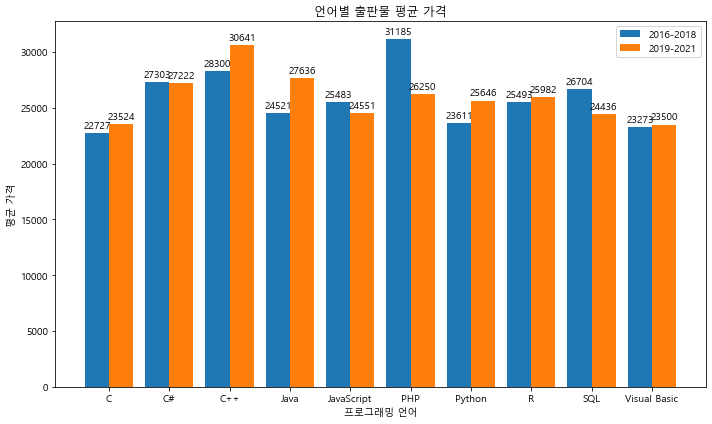

In [368]:
width = 0.4

fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(avg_p_books_p1['language'].unique()))
p1 = ax.bar(x - 0.2, avg_p_books_p1.price, width, label='2016-2018')
p2 = ax.bar(x + 0.2, avg_p_books_p2.price, width, label='2019-2021')

ax.set_xlabel('프로그래밍 언어')
ax.set_ylabel('평균 가격')
ax.set_title('언어별 출판물 평균 가격')
ax.set_xticks(x)
ax.set_xticklabels(avg_p_books_p1['language'].unique())
ax.legend()

ax.bar_label(p1,fmt='%.0f', padding=3)
ax.bar_label(p2, fmt='%.0f', padding=3)

fig.tight_layout()
plt.show();

- 2016-18년 대비 2019-21년에 Python 관련 출판물의 평균 가격은 8.6% 증가

## 5. 도서 페이지 수와 가격 관계 분석 
- 페이지 수가 가격에 영향을 주지 않을까?
- 페이지 수와 가격 회귀분석 진행
- 페이지 수로 가격 예측 진행

### 페이지 수와 가격 관계 분석 -- 회귀분석

In [378]:
# IQR 기반 이상치 검출
def get_outlier(data, rate=1.5): #이상치 기준 범위를 줄이고 싶으면 1.5보다 작게 잡으면 됨
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR*rate) | (data > q3 + IQR*rate) # q1 - IQR*rate: lower fence / q3 + IQR*rate: upper fence

In [382]:
# 이상치에 해당하는 가격 조회
book_df[get_outlier(book_df['price'])]['price'].value_counts().sort_index()

44000.0      7
45000.0     33
46800.0      1
47000.0      1
48000.0      9
49000.0      1
50000.0     20
51000.0      1
52000.0      1
53000.0      3
54000.0      3
54800.0      1
55000.0      6
56000.0      1
58000.0      4
59000.0      2
60000.0      4
62000.0      1
65000.0      2
68000.0      3
70000.0      1
75000.0      1
76000.0      1
77400.0      1
78000.0      1
81980.0      1
88000.0      1
98000.0      1
108000.0     1
109360.0     1
118000.0     1
160000.0     1
Name: price, dtype: int64

In [403]:
book_df[get_outlier(book_df['price'])]['publisher_nationality'].value_counts()

한국출판사    109
외국출판사      7
Name: publisher_nationality, dtype: int64

In [431]:
book_df[get_outlier(book_df['price'])]['page_num'].value_counts().index

Float64Index([ 956.0,  780.0,  772.0,  696.0,  692.0,  700.0,  904.0, 1004.0,
              1184.0, 1000.0,
              ...
              1280.0, 1711.0, 1706.0, 1234.0,  180.0, 1731.0,  984.0, 1352.0,
              1248.0,  928.0],
             dtype='float64', length=103)

In [376]:
# 특별히 비싼 책 조회
book_df[book_df['price']>100000]

title  \
1617  보안 코딩 세트 (개발자가 바로 사용할 수 있는, 전4권,한정판,버그 없는 안전한 ...   
2019  PROGRAMMING 32-BIT MICROCONTROLLERS IN C (Pape...   
3090  스프링과 JPA를 활용한 자바 엔터프라이즈 애플리케이션 개발 세트 (전3권,자바 O...   
5703                    SQL SERVER TRAINING (MICROSOFT)   

                                                 author     price  page_num  \
1617  로버트 <b>C</b>. 시코드|조나단 지드자스키|빌리 호프만|브라이언 설리번|마이...  118000.0    1948.0   
2019                                     Di Jasio|Lucio  109360.0     600.0   
3090                                            김영한|이일민  108000.0    2456.0   
5703                                           MS PRESS  160000.0    1000.0   

                  publisher  pub_date  year month language  \
1617                  에이콘출판  20130101  2013    01        C   
2019  Butterworth-Heinemann  20080214  2008    02        C   
3090                  에이콘출판  20150731  2015    07     Java   
5703                    삼각형  19980109  1998    01      SQL   

     publisher_nationality  count  
1617                 한국출판사      1  
2019                 외국출판사      1  
3090                 한국출판사      1  
5703                 한국출판사      1

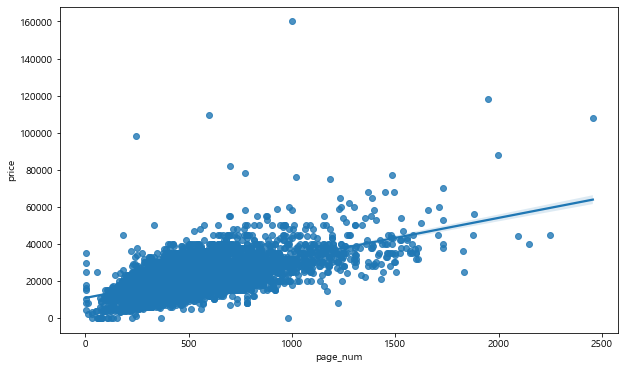

In [369]:
# 페이지 수와 가격 관계 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import set_matplotlib_hangul
%matplotlib inline

plt.figure(figsize=(10,6))
sns.regplot(x='page_num', y='price', data=book_df)
plt.show();

- 페이지 수와 가격 사이에 관계가 있다고 볼 수 있다.

### 출판사별 페이지 수와 가격 관계 분석 

In [384]:
# 출판사 수
len(book_df['publisher'].unique())

556

In [402]:
# 출판사별 조회
book_df['publisher'].value_counts().to_frame().head(10)

publisher
한빛미디어                    366
에이콘출판                    278
정보문화사                    278
영진닷컴                     227
Packt(GCOScience)        155
성안당                      137
홍릉과학출판사                  133
인포북                      133
대림                       125
위키북스                     113

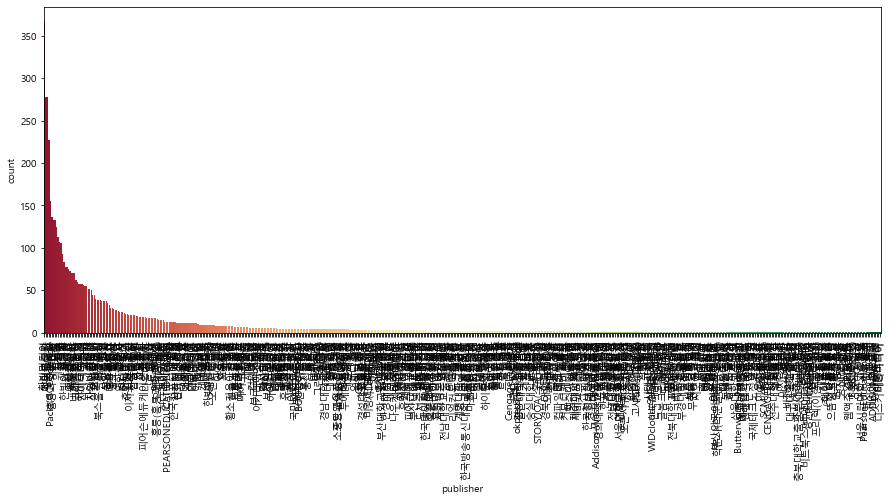

In [385]:
plt.figure(figsize=(15,6))
sns.countplot('publisher', data=book_df, palette='RdYlGn',
              order=book_df['publisher'].value_counts().index)
plt.xticks(rotation=90)
plt.show();

- 출판사별 편중이 심한 것 같다

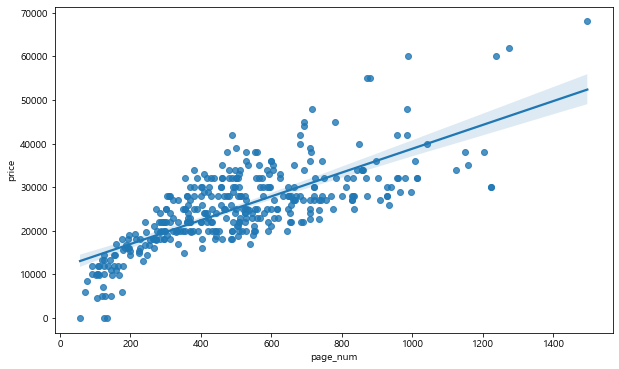

In [404]:
# 특정 출판사별 페이지 수와 가격 관계 시각화
raw_1 = book_df[book_df['publisher']=='한빛미디어']
plt.figure(figsize=(10,6))
sns.regplot(x='page_num', y='price', data=raw_1)
plt.show();

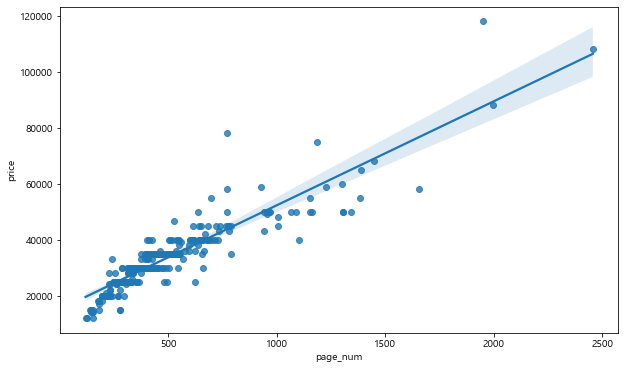

In [408]:
raw_2 = book_df[book_df['publisher']=='에이콘출판']
plt.figure(figsize=(10,6))
sns.regplot(x='page_num', y='price', data=raw_2)
plt.show();

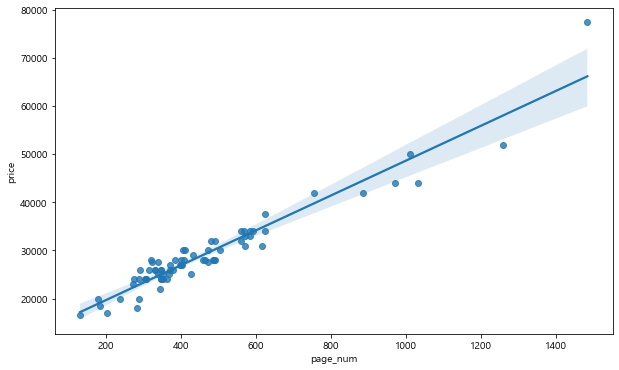

In [409]:
raw_3 = book_df[book_df['publisher']=='비제이퍼블릭']
plt.figure(figsize=(10,6))
sns.regplot(x='page_num', y='price', data=raw_3)
plt.show();

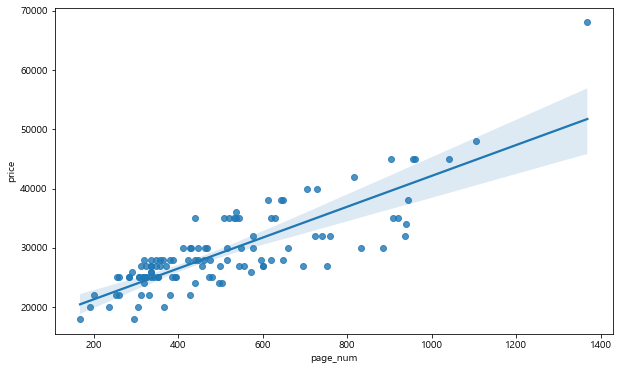

In [410]:
raw_4 = book_df[book_df['publisher']=='위키북스']
plt.figure(figsize=(10,6))
sns.regplot(x='page_num', y='price', data=raw_4)
plt.show();

- 출판사별로는 가격을 보다 잘 예측 할 수 있을 것 같다.

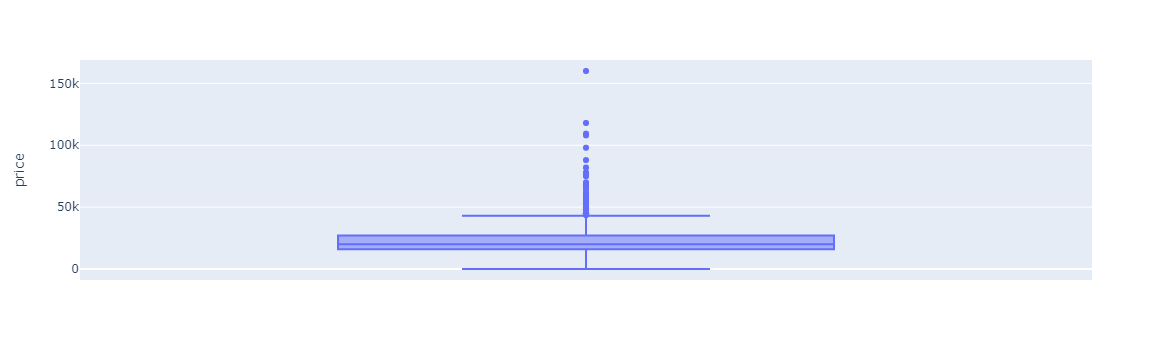

In [394]:
import plotly.express as px
px.box(book_df, y='price')

### 도서 페이지 수 데이터로 도서 가격 예측

In [395]:
# 회귀 모델 구성을 위한 데이터 나누기
from sklearn.model_selection import train_test_split

X = book_df['page_num'].values
y = book_df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [398]:
# 모델 학습
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [399]:
# 에러 계산
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

print('RMSE of Train Data :', rmse_tr)
print('RMSE of Test Data :', rmse_test)

RMSE of Train Data : 7473.55295963557
RMSE of Test Data : 6951.063020967673


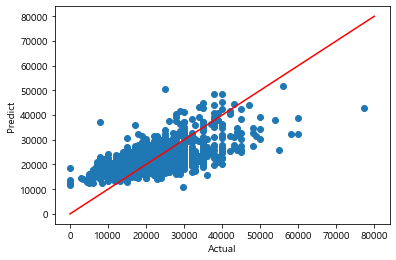

In [400]:
# 참값과 예측값
plt.scatter(y_test, pred_test)
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.plot([0,80000],[0,80000],'r')
plt.show();

RMSE of Train Data : 5645.794719237149
RMSE of Test Data : 3873.7934302270933


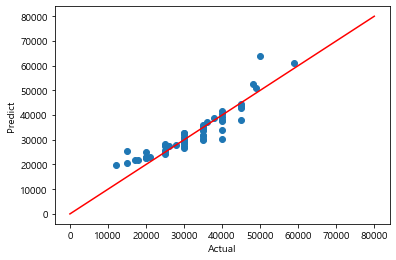

In [414]:
# 이번엔 특정 출판사에 대해 예측
X = raw_2['page_num'].values
y = raw_2['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

reg.fit(X_train, y_train)

# 예측
pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

# 에러 계산
print('RMSE of Train Data :', rmse_tr)
print('RMSE of Test Data :', rmse_test)

# 참값과 예측값
plt.scatter(y_test, pred_test)
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.plot([0,80000],[0,80000],'r')
plt.show();

- 의미가 있다고 보인다.
- 도서 페이지 수는 도서 가격에 영향이 있으며, 페이지 수가 많을수록 가격도 높다고 생각한다.

---

# 4. 결론 

- TIOBE Index와 같이 Python은 가장 인기가 많은 프로그래밍 언어이며, 그 인기는 관련 출판 도서 수에서도 나타난다. 최근 6년간 프로그래밍 언어 중에서 매년 가장 많은 도서가 출판되었으며, 2018년부터 매년 100권 넘게 출판되고 있는 것으로 보아 그 인기는 여전한 것으로 생각한다.
- 도서 가격에 페이지 수가 큰 영향을 준다. 페이지 수가 많을수록 높은 가격을 보인다.